# **Importing Libraries**

In [1]:
import pandas as pd
import logging
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import requests

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# **Setting Loggings**

In [3]:
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.FileHandler("data_cleaning.log"), logging.StreamHandler()]
)

logging.info("Initial logging setup completed.")

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)


In [4]:
logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.FileHandler("Projectlogfile.log"), logging.StreamHandler()]
)

logging.info("Log settings have been reset.")


2024-12-28 13:04:00,079 - INFO - Log settings have been reset.


# **Loading Data**

In [5]:
try:
  df = pd.read_csv("DataSet.csv")
  logging.info("Data loaded successfully.")
except Exception as e:
  logging.error(f"Error occurred while uploading/reading dataset: {e}")

2024-12-28 13:04:01,560 - INFO - Data loaded successfully.


In [6]:
df.head()

,date,values,name
0,2024-05-03T10:15:01.506+05:00,3520774.4,Solar 1
1,2024-05-03T12:45:01.901+05:00,3522110.6,Solar 1
2,2024-05-03T12:45:21.917+05:00,3522112.2,Solar 1
3,2024-05-03T13:00:57.682+05:00,3522169.9,Solar 1
4,2024-05-03T13:30:31.328+05:00,3522337.0,Solar 1


# **Data preprocessing**

In [7]:
logging.debug("Starting Data Cleaning TASK.")
logging.info(df.isnull().sum())

2024-12-28 13:04:04,728 - DEBUG - Starting Data Cleaning TASK.
2024-12-28 13:04:04,736 - INFO - date      0
values    0
name      0
dtype: int64


In [8]:
logging.debug("Starting Data Preprocessing TASK.")
df.drop(columns=["name"], inplace=True)

2024-12-28 13:04:06,131 - DEBUG - Starting Data Preprocessing TASK.


In [9]:
df.head()

,date,values
0,2024-05-03T10:15:01.506+05:00,3520774.4
1,2024-05-03T12:45:01.901+05:00,3522110.6
2,2024-05-03T12:45:21.917+05:00,3522112.2
3,2024-05-03T13:00:57.682+05:00,3522169.9
4,2024-05-03T13:30:31.328+05:00,3522337.0


In [10]:
logging.info(df.dtypes)

2024-12-28 13:04:09,722 - INFO - date       object
values    float64
dtype: object


**Converting Column to Datetime:**

In [11]:
logging.info("Converting Column to Datetime:")
df['date'] = pd.to_datetime(df['date'])

2024-12-28 13:04:26,821 - INFO - Converting Column to Datetime:


In [12]:
logging.info(df.dtypes)

2024-12-28 13:04:31,105 - INFO - date      datetime64[ns, UTC+05:00]
values                      float64
dtype: object


In [13]:
logging.info(f"Number of rows: {len(df)}")

2024-12-28 13:04:32,025 - INFO - Number of rows: 17718


**Adding a New Column:**

In [14]:
df['date_only'] = df['date'].dt.date

**Aggregating Data:**

In [15]:
try:
  preprocessed_df = df.groupby('date_only').agg(
      value_difference=('values', lambda x: x.iloc[-1] - x.iloc[0])
  ).reset_index()
  logging.info("Data aggregation completed successfully.")
except:
  logging.error("Error occurred while aggregating data.")

2024-12-28 13:04:35,711 - INFO - Data aggregation completed successfully.


**Renaming Columns:**

In [16]:
preprocessed_df.rename(columns={"date_only":"date", "value_difference":"production"}, inplace=True)

In [17]:
preprocessed_df

,date,production
0,2024-05-03,2127.6
1,2024-05-04,5377.3
2,2024-05-05,5924.9
3,2024-05-06,6308.3
4,2024-05-07,6135.8
...,...,...
189,2024-11-15,959.6
190,2024-11-16,1219.4
191,2024-11-17,2606.5
192,2024-11-18,2822.9


In [18]:
logging.info(preprocessed_df.info())

2024-12-28 13:04:41,291 - INFO - None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        194 non-null    object 
 1   production  194 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.2+ KB


# **Statistical Analysis**

In [19]:
preprocessed_df['date'] = pd.to_datetime(preprocessed_df['date'])
preprocessed_df.set_index('date', inplace=True)

**Plotting Time Series:**

In [20]:
# Suppress matplotlib font warnings
matplotlib_logger = logging.getLogger('matplotlib')
matplotlib_logger.setLevel(logging.WARNING)

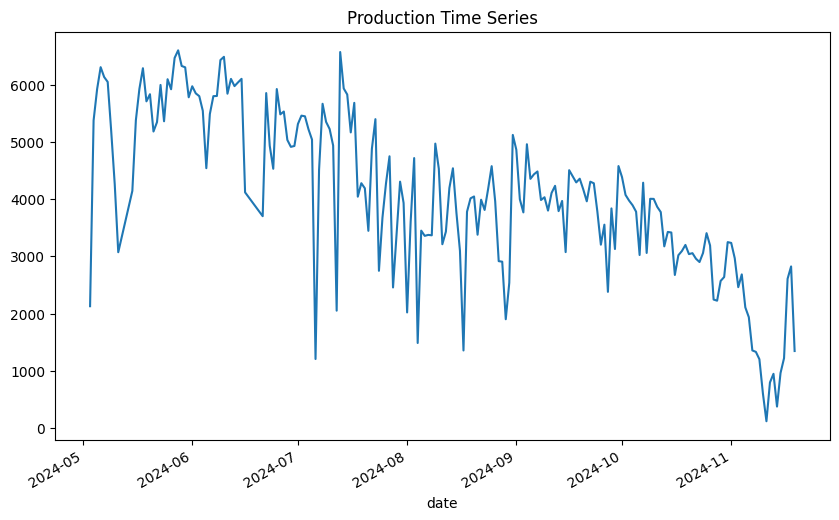

In [21]:
preprocessed_df['production'].plot(figsize=(10, 6), title='Production Time Series')
plt.show()


**Checking Stationarity:**

In [22]:
logging.info("Checking Stationarity of the Dataset:")

result = adfuller(preprocessed_df['production'])
logging.info(f'ADF Statistic: {result[0]}')
logging.info(f'p-value: {result[1]}')

if result[1] < 0.05:
    logging.info("The series is stationary.")
else:
    logging.info("The series is non-stationary.")

2024-12-28 13:04:46,630 - INFO - Checking Stationarity of the Dataset:
2024-12-28 13:04:46,663 - INFO - ADF Statistic: -1.2989872864001704
2024-12-28 13:04:46,665 - INFO - p-value: 0.6296355039286008
2024-12-28 13:04:46,666 - INFO - The series is non-stationary.


#### Data is non stationary

# **Data Transformation:**

**Differencing:**

2024-12-28 13:04:48,459 - INFO - Checking Data Transformation by applying first differencing:


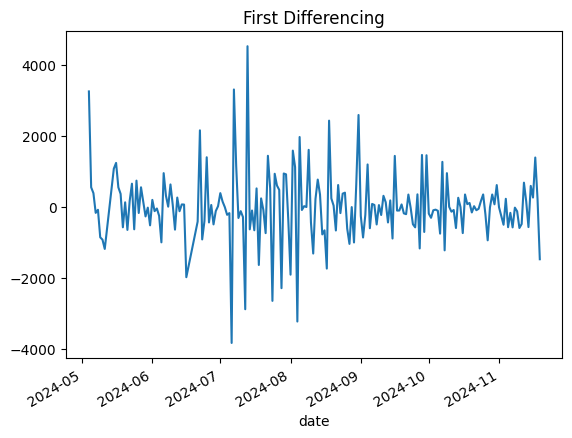

2024-12-28 13:04:48,847 - INFO - ADF Statistic: -10.738166986310185
2024-12-28 13:04:48,851 - INFO - p-value: 2.86325960198998e-19
2024-12-28 13:04:48,853 - INFO - The series is stationary.


In [23]:
logging.info("Checking Data Transformation by applying first differencing:")
preprocessed_df['production_diff'] = preprocessed_df['production'].diff()
preprocessed_df['production_diff'].dropna().plot(title="First Differencing")
plt.show()

# Check stationarity
result = adfuller(preprocessed_df['production_diff'].dropna())
logging.info(f'ADF Statistic: {result[0]}')
logging.info(f'p-value: {result[1]}')

if result[1] < 0.05:
    logging.info("The series is stationary.")
else:
    logging.info("The series is non-stationary.")

**Log Transformation:**

2024-12-28 13:04:52,191 - INFO - Checking Data Transformation by applying Log Transformation:


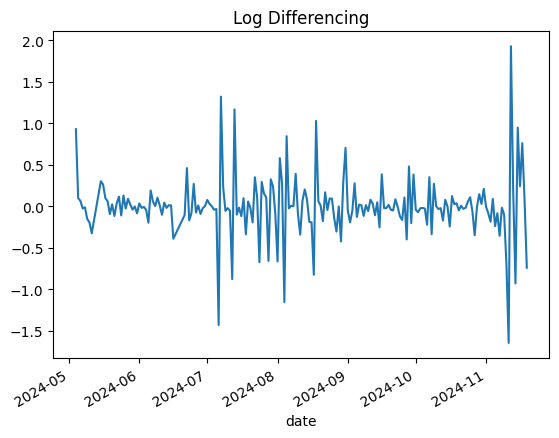

2024-12-28 13:04:52,705 - INFO - ADF Statistic: -6.593909172573793
2024-12-28 13:04:52,708 - INFO - p-value: 7.0028279738835536e-09
2024-12-28 13:04:52,713 - INFO - The series is stationary.


In [24]:
logging.info("Checking Data Transformation by applying Log Transformation:")
preprocessed_df['production_log'] = np.log(preprocessed_df['production'])

preprocessed_df['production_log_diff'] = preprocessed_df['production_log'].diff()
preprocessed_df['production_log_diff'].dropna().plot(title="Log Differencing")
plt.show()

# Check stationarity
result = adfuller(preprocessed_df['production_log_diff'].dropna())
logging.info(f'ADF Statistic: {result[0]}')
logging.info(f'p-value: {result[1]}')


if result[1] < 0.05:
    logging.info("The series is stationary.")
else:
    logging.info("The series is non-stationary.")

**Seasonal Adjustment**

2024-12-28 13:04:55,105 - INFO - Checking Data Transformation by applying Seasonal Differencing:


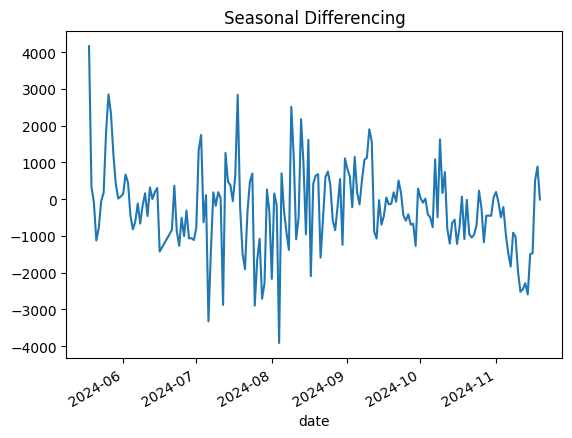

2024-12-28 13:04:56,527 - INFO - ADF Statistic: -3.671462656643458
2024-12-28 13:04:56,541 - INFO - p-value: 0.004532941113610218
2024-12-28 13:04:56,548 - INFO - The series is stationary.


In [25]:
logging.info("Checking Data Transformation by applying Seasonal Differencing:")
preprocessed_df['seasonal_diff'] = preprocessed_df['production'] - preprocessed_df['production'].shift(12)
preprocessed_df['seasonal_diff'].dropna().plot(title="Seasonal Differencing")
plt.show()

# Check stationarity
result = adfuller(preprocessed_df['seasonal_diff'].dropna())
logging.info(f'ADF Statistic: {result[0]}')
logging.info(f'p-value: {result[1]}')


if result[1] < 0.05:
    logging.info("The series is stationary.")
else:
    logging.info("The series is non-stationary.")

**ACF and PACF**

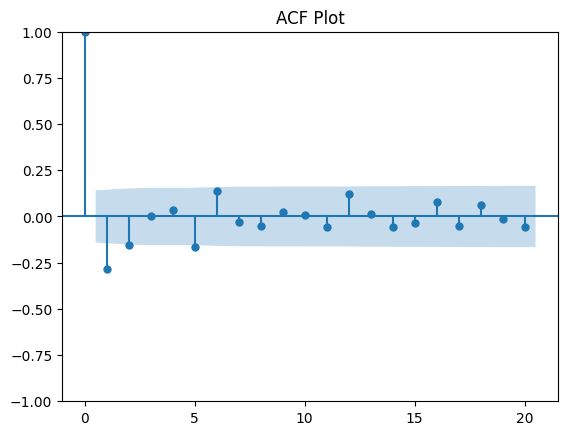

In [26]:
plot_acf(preprocessed_df['production_diff'].dropna(), lags=20, title="ACF Plot")
plt.show()

In [27]:
logging.info("""The presence of a strong autocorrelation at lag 1 confirms that the immediate past significantly influences the current value.
                For ARIMA modeling, this suggests that the moving average component (q) could be small, possibly 1 (MA(1)).""")

2024-12-28 13:05:00,558 - INFO - The presence of a strong autocorrelation at lag 1 confirms that the immediate past significantly influences the current value.
                For ARIMA modeling, this suggests that the moving average component (q) could be small, possibly 1 (MA(1)).


### ACF Plot:
- #### The ACF plot shows significant autocorrelation at lag 1, which then quickly drops and oscillates within the confidence interval.
- #### This suggests that the series has little to no strong autocorrelation after the first lag, indicating that MA(1) (Moving Average with one lag) might be sufficient.

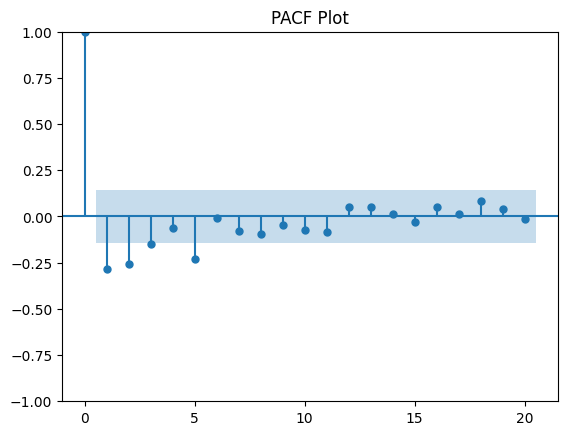

In [28]:
plot_pacf(preprocessed_df['production_diff'].dropna(), lags=20, title="PACF Plot")
plt.show()

In [29]:
logging.info("""Since only lag 1 is significantly large, this suggests that the series is primarily influenced by its immediate past value (lag 1).
              For ARIMA modeling, this indicates that the autoregressive component (p) of the model might be 1 (AR(1)).""")

2024-12-28 13:05:03,716 - INFO - Since only lag 1 is significantly large, this suggests that the series is primarily influenced by its immediate past value (lag 1).
              For ARIMA modeling, this indicates that the autoregressive component (p) of the model might be 1 (AR(1)).


### PACF Plot:
- #### The PACF plot shows a significant spike at lag 1 and possibly smaller spikes around lag 2, after which the values fall within the confidence interval.
- #### This suggests that the series might require an AR(1) (AutoRegressive with one lag) or possibly an AR(2).

# **ARIMA Modeling**

**Previous used train & test (without adding new variables)**

In [30]:
train_size = int(len(preprocessed_df) * 0.8)
train, test = preprocessed_df.iloc[:train_size], preprocessed_df.iloc[train_size:]

**Model Training:**

In [31]:
logging.info("Model Training through ARIMA:")
p, d, q = 1, 1, 1
# p, d, q = 2, 1, 1

model = ARIMA(train['production'], order=(p, d, q))
model_fit = model.fit()

2024-12-28 13:05:06,716 - INFO - Model Training through ARIMA:
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [32]:
logging.info(model_fit.summary())

2024-12-28 13:05:07,909 - INFO -                                SARIMAX Results                                
Dep. Variable:             production   No. Observations:                  155
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1271.610
Date:                Sat, 28 Dec 2024   AIC                           2549.219
Time:                        13:05:07   BIC                           2558.330
Sample:                             0   HQIC                          2552.920
                                - 155                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2945      0.085      3.480      0.001       0.129       0.460
ma.L1         -0.8935      0.048    -18.681      0.000      -0.987      -0.800
sigma2      8.643e+

**Residuals are the differences between the actual observed values and the values predicted by the model:**

Residual=Actual Value−Predicted Value

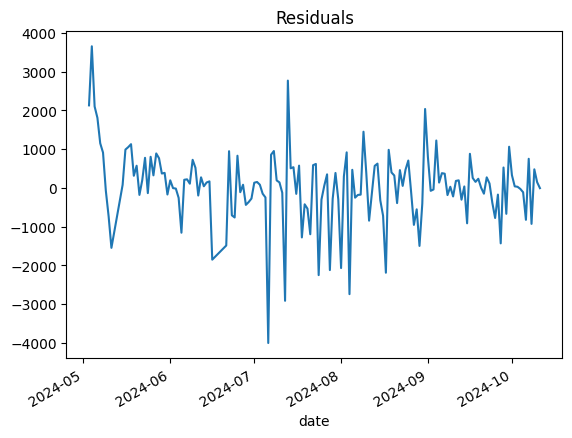

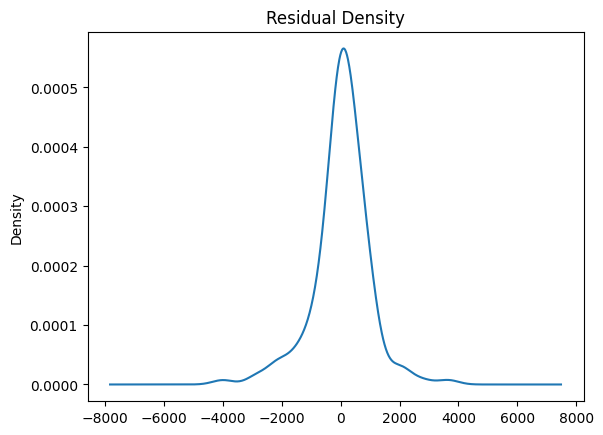

In [33]:
residuals = model_fit.resid
residuals.plot(title="Residuals")
plt.show()
residuals.plot(kind='kde', title="Residual Density")
plt.show()

# A small residual means the model's prediction is close to the actual value.
# A large residual indicates a poor prediction for that data point.

# Normally distributed residuals suggest the model is well-specified.
# Skewed or multi-modal distributions indicate issues with the model.

# **Model Inference**

In [34]:

# Validate on test data
logging.info("Model Validation STARTED.")
forecast_steps = len(test)
val_forecast = model_fit.forecast(steps=forecast_steps)
logging.info("Validation Values:")
logging.info(val_forecast)

2024-12-28 13:05:14,581 - INFO - Model Validation STARTED.
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
2024-12-28 13:05:14,590 - INFO - Validation Values:
2024-12-28 13:05:14,591 - INFO - 155    3832.764197
156    3823.240854
157    3820.436097
158    3819.610057
159    3819.366777
160    3819.295128
161    3819.274026
162    3819.267811
163    3819.265981
164    3819.265442
165    3819.265283
166    3819.265236
167    3819.265222
168    3819.265218
169    3819.265217
170    3819.265217
171    3819.265217
172    3819.265217
173    3819.265217
174    3819.265217
175    3819.265217
176    3819.265217
177    3819.265217
178    3819.265217
179    3819.265217
180    3819.265217
181    3819.265217
182    3819.265217
183    3819.265217
184    3819.265217
185    3819.265217
186    3819.265217
187    3819.26

In [35]:
logging.info(f"Validation Values Shape: {val_forecast.shape}")
logging.info(f"Test Data Shape: {test.shape}")

2024-12-28 13:05:18,118 - INFO - Validation Values Shape: (39,)
2024-12-28 13:05:18,122 - INFO - Test Data Shape: (39, 5)


In [36]:
# Evaluate validation performance
logging.info("Calculating Mean Absolute Error and Root Mean Squared Error for ARIMA:")
mae = mean_absolute_error(test['production'], val_forecast)
rmse = np.sqrt(mean_squared_error(test['production'], val_forecast))
logging.info(f"MAE: {mae}")
logging.info(f"RMSE: {rmse}")

2024-12-28 13:05:20,007 - INFO - Calculating Mean Absolute Error and Root Mean Squared Error for ARIMA:
2024-12-28 13:05:20,015 - INFO - MAE: 1477.232762741717
2024-12-28 13:05:20,017 - INFO - RMSE: 1772.716834914319


In [37]:
# Forecast future steps (beyond the test data)
logging.info("ARIMA Model Forecasting STARTED.")
future_forecast_steps = 7
future_forecast = model_fit.forecast(steps=future_forecast_steps)
logging.info(f"Forecasted Values (next {future_forecast_steps} days): {future_forecast}")

2024-12-28 13:05:32,002 - INFO - ARIMA Model Forecasting STARTED.
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
2024-12-28 13:05:32,011 - INFO - Forecasted Values (next 7 days): 155    3832.764197
156    3823.240854
157    3820.436097
158    3819.610057
159    3819.366777
160    3819.295128
161    3819.274026
Name: predicted_mean, dtype: float64


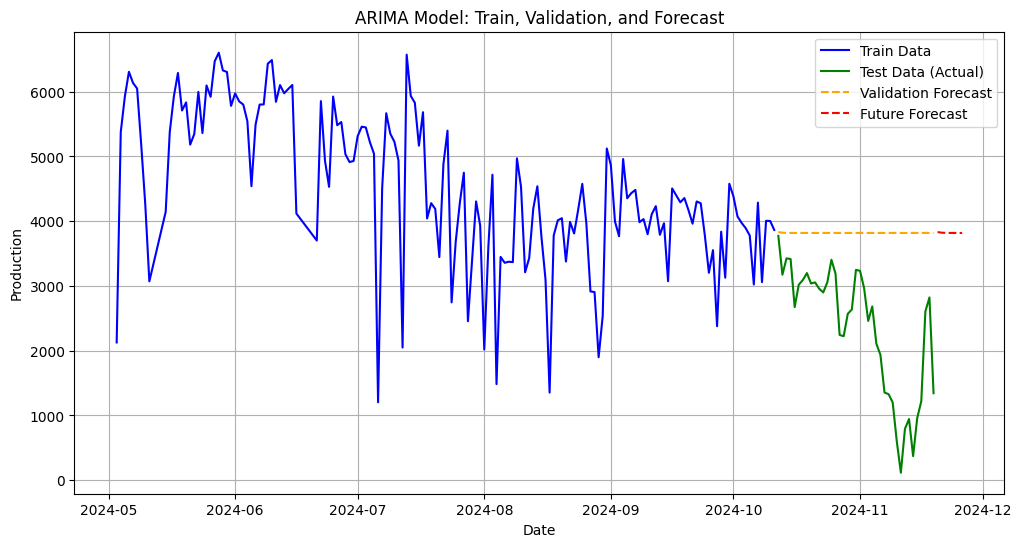

In [38]:
# Plot results
plt.figure(figsize=(12, 6))

# Plot train data
plt.plot(train['production'], label='Train Data', color='blue')

# Plot test data
plt.plot(test['production'], label='Test Data (Actual)', color='green')

# Plot validation forecast
plt.plot(test.index, val_forecast, label='Validation Forecast', color='orange', linestyle='--')


# Plot future forecast
future_forecast_index = pd.date_range(test.index[-1], periods=future_forecast_steps + 1, freq='D')[1:]
plt.plot(future_forecast_index, future_forecast, label='Future Forecast', color='red', linestyle='--')

plt.legend()
plt.title("ARIMA Model: Train, Validation, and Forecast")
plt.xlabel("Date")
plt.ylabel("Production")
plt.grid(True)

plt.show()

# **2nd Week's Tasks**

# **Implementing Hyperparamater Tuning & New Models**

In [39]:
%%capture
!pip install pmdarima

**Importing Libraries**

In [40]:
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [41]:
logging.info("Auto ARIMA Hypertuning STARTED.")

2024-12-28 13:05:54,909 - INFO - Auto ARIMA Hypertuning STARTED.


p (AutoRegression): How many past values (lags) should we consider? For example:
If p=1, the current value is influenced by just the last value.
If p=2, it's influenced by the last two values.
start_p: Start the search from 0 (no influence of past values).
max_p: Go up to 3 (check the influence of up to 3 past values).


q (Moving Average): How many past errors should we consider?
If q=1, the model considers the last prediction error.
If q=2, it considers the last two prediction errors.
start_q: Start the search from 0 (no influence of past errors).
max_q: Check up to 3 past errors

stepwise: What it does: Instead of testing all combinations of p, d, and q, it takes smarter steps to find the best combination faster.

trace: What it does: Shows the process of trying different combinations of p, d, and q values.

In [42]:
# Auto ARIMA model (search for best p, d, q)
auto_arima_model = auto_arima(
    train["production"],
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    seasonal=False,  # For ARIMA (set True for SARIMA)
    stepwise=True,
    trace=True,  # Displays the parameter grid search process
    error_action='ignore',
    suppress_warnings=True
)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2592.268, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2581.652, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2559.025, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2590.288, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2550.796, Time=0.45 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2551.277, Time=0.79 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2551.585, Time=0.39 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2549.605, Time=0.24 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=2551.634, Time=0.22 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=2551.643, Time=0.50 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=2547.953, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=2557.180, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=2550.323, Time=0.08 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=2550.015, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0]          

In [43]:
#(0,0,0) - seasonal components

# Summary of the chosen ARIMA model
logging.info(auto_arima_model.summary())

2024-12-28 13:05:58,450 - INFO -                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  155
Model:               SARIMAX(0, 1, 2)   Log Likelihood               -1270.976
Date:                Sat, 28 Dec 2024   AIC                           2547.953
Time:                        13:05:58   BIC                           2557.063
Sample:                             0   HQIC                          2551.653
                                - 155                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5819      0.070     -8.276      0.000      -0.720      -0.444
ma.L2         -0.2648      0.080     -3.319      0.001      -0.421      -0.108
sigma2      8.358e+

In [44]:
#If a previous error (L1 or L2) was negative, the model adjusts the prediction downward.
# L1 (Q): A high P-value (>0.05) indicates no significant autocorrelation in the residuals. This is good.

# JB : A low P-value (<0.05) indicates residuals are not normal.

# H: A low P-value (<0.05) indicates heteroskedasticity (variance changes over time).

In [45]:
logging.info("Fitting the ARIMA Model with tuned paramaters: ")
best_p = 0
best_d = 1
best_q = 2

# Initialize ARIMA model with the tuned parameters
arima_model = ARIMA(
    train["production"],
    order=(best_p, best_d, best_q)
)


# Fit the ARIMA model
arima_result = arima_model.fit()

logging.info(arima_result.summary())

2024-12-28 13:05:59,231 - INFO - Fitting the ARIMA Model with tuned paramaters: 
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
2024-12-28 13:05:59,358 - INFO -                                SARIMAX Results                                
Dep. Variable:             production   No. Observations:

**Model Training for Auto ARIMA**

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


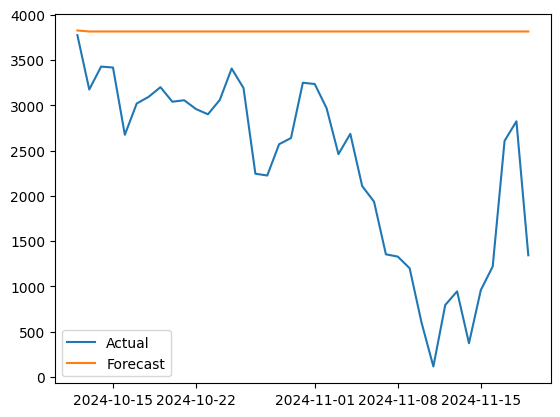

2024-12-28 13:06:02,765 - INFO - Evaluation Performance of AUTO-ARIMA: 
2024-12-28 13:06:02,768 - INFO - MAE: 1472.1092283077794
2024-12-28 13:06:02,770 - INFO - RMSE: 1768.5704708332967


In [46]:
# Forecast on the test set
auto_arima_val_forecast = arima_result.forecast(steps=len(test))

# Plot actual vs forecast
plt.plot(test.index, test["production"], label='Actual')
plt.plot(test.index, auto_arima_val_forecast, label='Forecast')
plt.legend()
plt.show()

# Evaluate the performance
mae = mean_absolute_error(test["production"], auto_arima_val_forecast)
mse = mean_squared_error(test["production"], auto_arima_val_forecast)
rmse = np.sqrt(mse)
logging.info("Evaluation Performance of AUTO-ARIMA: ")
logging.info(f"MAE: {mae}")
logging.info(f"RMSE: {rmse}")

In [47]:
auto_arima_final_model = auto_arima(
    preprocessed_df['production'],
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    seasonal=False,
    stepwise=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3214.461, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3202.063, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3182.080, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3212.467, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3169.353, Time=0.88 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=3170.148, Time=1.57 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=3170.208, Time=2.30 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=3168.444, Time=2.49 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=3170.268, Time=3.44 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=3170.012, Time=4.39 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=3168.050, Time=1.05 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=3180.550, Time=0.40 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=3169.888, Time=1.21 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=3170.095, Time=0.64 sec
 ARIMA(1,1,1)(0,0,0)[0]          

In [48]:
# Forecast future periods
auto_arima_future_forecast = auto_arima_final_model.predict(n_periods=12)
logging.info("Auto ARIMA Future Forecasting: ")
logging.info(auto_arima_future_forecast)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
2024-12-28 13:06:26,973 - INFO - Auto ARIMA Future Forecasting: 
2024-12-28 13:06:26,979 - INFO - 194    1391.590810
195    1549.602812
196    1549.602812
197    1549.602812
198    1549.602812
199    1549.602812
200    1549.602812
201    1549.602812
202    1549.602812
203    1549.602812
204    1549.602812
205    1549.602812
dtype: float64


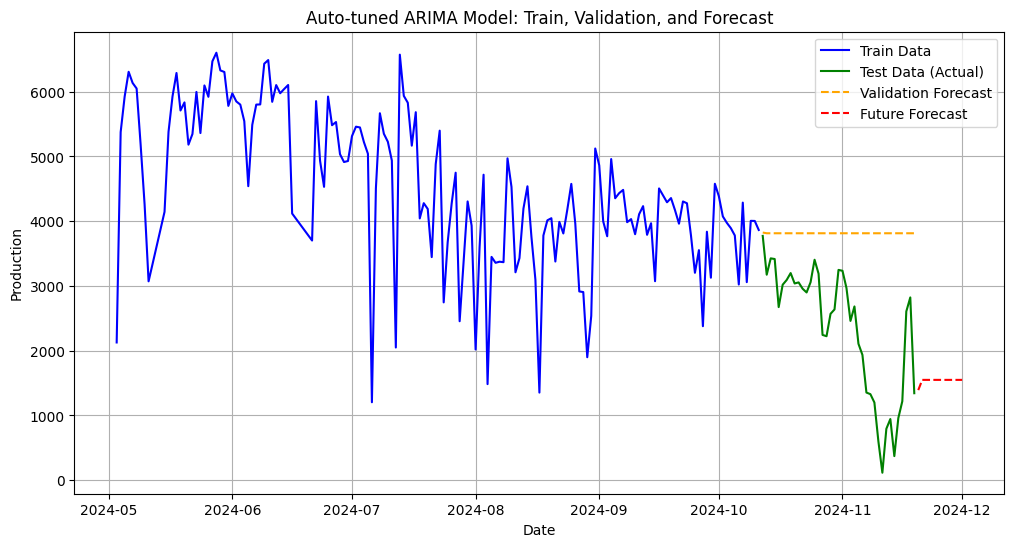

In [49]:
# Plot results
plt.figure(figsize=(12, 6))

# Plot train data
plt.plot(train['production'], label='Train Data', color='blue')

# Plot test data
plt.plot(test['production'], label='Test Data (Actual)', color='green')

# Plot validation forecast
plt.plot(test.index, auto_arima_val_forecast, label='Validation Forecast', color='orange', linestyle='--')


# Plot future forecast
future_forecast_index = pd.date_range(test.index[-1], periods=12 + 1, freq='D')[1:]
plt.plot(future_forecast_index, auto_arima_future_forecast, label='Future Forecast', color='red', linestyle='--')

plt.legend()
plt.title("Auto-tuned ARIMA Model: Train, Validation, and Forecast")
plt.xlabel("Date")
plt.ylabel("Production")
plt.grid(True)

plt.show()

# **Applying Seasonal ARIMA (SARIMA)**

In [50]:
logging.info("Seasonal ARIMA Hypertuning STARTED.")

# Seasonal ARIMA model (SARIMA)
sarima_model = auto_arima(
    train['production'],  # Fit on training data only
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    start_P=0, max_P=3,  # Seasonal AR terms
    start_Q=0, max_Q=3,  # Seasonal MA terms
    m=12,  # Seasonal frequency (e.g., 12 for monthly data)
    seasonal=True,
    stepwise=True,
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)

2024-12-28 13:06:28,589 - INFO - Seasonal ARIMA Hypertuning STARTED.


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2592.268, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2580.267, Time=2.24 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2556.366, Time=3.90 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2590.288, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=2559.025, Time=1.05 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=2557.987, Time=4.33 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=2557.819, Time=7.88 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=2557.265, Time=2.44 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=inf, Time=12.22 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=2591.044, Time=0.07 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=2548.587, Time=0.71 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=2550.796, Time=0.25 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=2549.993, Time=1.05 sec
 ARIMA(1,1,1)(0,0,2)[12] intercept   : AIC=2549.835, Time=1.78 sec
 ARIMA(1,1,1)(1,0,0)[12

In [51]:
# Summary of the chosen SARIMA model
logging.info(sarima_model.summary())

2024-12-28 13:07:24,541 - INFO -                                       SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  155
Model:             SARIMAX(0, 1, 2)x(0, 0, [1], 12)   Log Likelihood               -1268.905
Date:                              Sat, 28 Dec 2024   AIC                           2545.811
Time:                                      13:07:24   BIC                           2557.958
Sample:                                           0   HQIC                          2550.745
                                              - 155                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5972      0.071     -8.428      0.000      -0.73

In [52]:
logging.info("Fitting the SARIMA Model with tuned paramaters: ")
best_p, best_d, best_q = 0, 1, 2
best_P, best_D, best_Q, best_m = 0, 0, 1, 12

# Initialize SARIMA model with the tuned parameters
sarima_manual_model = SARIMAX(
    train['production'],
    order=(best_p, best_d, best_q),
    seasonal_order=(best_P, best_D, best_Q, best_m)
)


# Fit the SARIMA model
sarima_result = sarima_manual_model.fit()

logging.info(sarima_result.summary())

2024-12-28 13:07:24,570 - INFO - Fitting the SARIMA Model with tuned paramaters: 
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
2024-12-28 13:07:24,887 - INFO -                                       SARIMAX Results                                       
Dep. Variable:                           production   No. Observations:                  155
Model:             SARIMAX(0, 1, 2)x(0, 0, [1], 12)   Log Likelihood               -1268.905
Date:                              Sat, 28 Dec 2024   AIC                           2545.811
Time:        

In [53]:
# 3. Validate on Test Data
# Forecast on the test data
forecast_steps = len(test)
val_sarima = sarima_result.forecast(steps=forecast_steps)
logging.info(f"Seasonal ARIMA Validation : {val_sarima}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
2024-12-28 13:07:24,921 - INFO - Seasonal ARIMA Validation : 155    4036.882667
156    3945.822042
157    3889.754357
158    3878.772918
159    3848.942688
160    3829.961319
161    3698.312369
162    3964.002113
163    3713.524108
164    3936.648786
165    3889.794560
166    3889.789347
167    3867.290368
168    3857.121334
169    3857.121334
170    3857.121334
171    3857.121334
172    3857.121334
173    3857.121334
174    3857.121334
175    3857.121334
176    3857.121334
177    3857.121334
178    3857.121334
179    3857.121334
180    3857.121334
181    3857.121334
182    3857.121334
183    3857.121334
184    3857.121334
185    3857.121334
186    3857.121334
187    3857.121334
188    3857.121334
189    3857.121334
190    3857.121334
191    3857.121334
19

In [54]:
# Evaluate performance
mae = mean_absolute_error(test['production'], val_sarima)
mse = mean_squared_error(test['production'], val_sarima)
rmse = np.sqrt(mse)
logging.info(f"Seasonal ARIMA Validation Performance - MAE: {mae:.2f}, RMSE: {rmse:.2f}")

2024-12-28 13:07:24,950 - INFO - Seasonal ARIMA Validation Performance - MAE: 1520.93, RMSE: 1805.52


In [55]:
# 4. Refit on Full Data for Final Forecasting
sarima_model.fit(preprocessed_df['production'])  # Refit on full data
future_forecast_steps = 7  # Forecast next 7 days
future_forecast_sarima = sarima_model.predict(n_periods=future_forecast_steps)
logging.info(f"SARIMA Forecast (next 7 days): {future_forecast_sarima}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
2024-12-28 13:07:25,100 - INFO - SARIMA Forecast (next 7 days): 194    1297.257303
195    1383.428255
196    1275.317865
197    1193.118162
198    1288.949402
199    1314.796925
200    1225.693325
dtype: float64


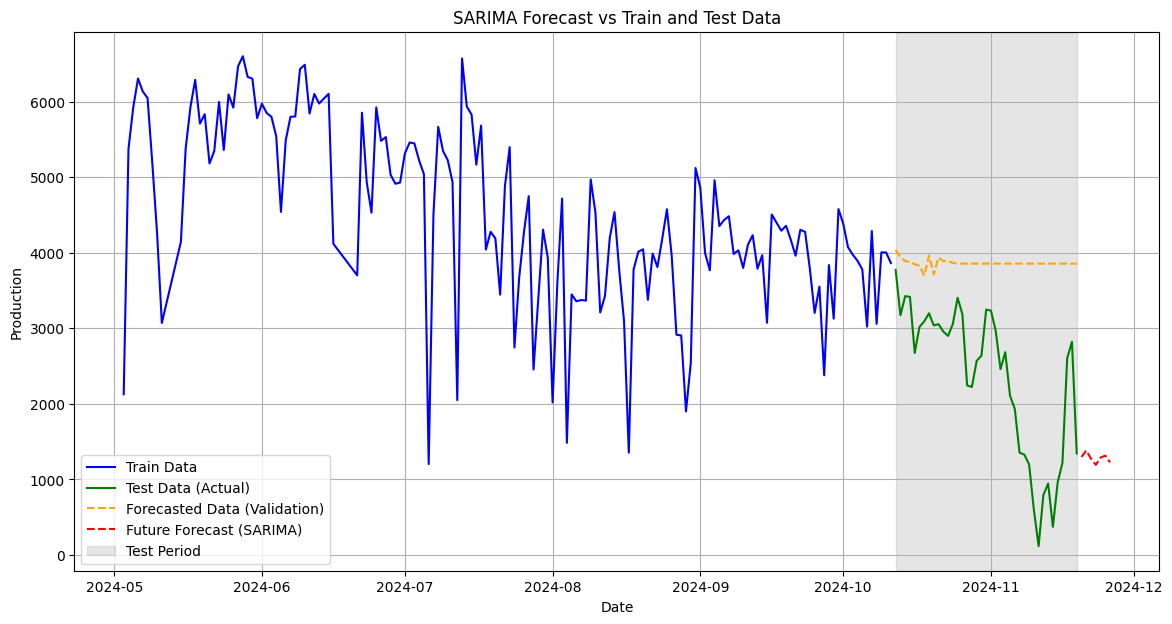

In [56]:
# Create a forecast index
forecast_index = pd.date_range(
    start=test.index[-1] + pd.Timedelta(days=1),  # Start after the test period
    periods=future_forecast_steps,
    freq='D'  # Adjust frequency to match your data
)

# Create a DataFrame for the forecast
future_forecast_df = pd.DataFrame({
    'date': forecast_index,
    'forecast': future_forecast_sarima
}).set_index('date')

# Plot train data
plt.figure(figsize=(14, 7))
plt.plot(train['production'], label="Train Data", color='blue')

# Plot test data
plt.plot(test['production'], label="Test Data (Actual)", color='green')


# Plot test forecast
plt.plot(test.index, val_sarima, label="Forecasted Data (Validation)", color='orange', linestyle='--')

# Plot future forecast
plt.plot(future_forecast_df.index, future_forecast_df['forecast'], label="Future Forecast (SARIMA)", color='red', linestyle='--')


# Highlight the test period for clarity
plt.axvspan(test.index[0], test.index[-1], color='gray', alpha=0.2, label="Test Period")

# Formatting
plt.title("SARIMA Forecast vs Train and Test Data")
plt.xlabel("Date")
plt.ylabel("Production")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# **Applying SARIMAX (SARIMA with Exogenous Variables)**

In [57]:
logging.info("SARIMAX Model Training STARTED.")


exog = preprocessed_df['production'].shift(1).fillna(0)


# Train SARIMAX Model on Training Data
sarimax_model = SARIMAX(
    train['production'],
    exog=exog.iloc[:len(train)],  # Exogenous variables for training
    order=(1, 1, 1),      # (p, d, q)
    seasonal_order=(1, 1, 1, 12)  # (P, D, Q, m)
)

sarimax_fitted = sarimax_model.fit(disp=False)

2024-12-28 13:07:25,598 - INFO - SARIMAX Model Training STARTED.
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [58]:
# Validate on Test Data
# Forecast on the test data
forecast_sarimax_test = sarimax_fitted.forecast(steps=len(test), exog=exog.iloc[len(train):])
logging.info(f"SARIMAX Validation: {forecast_sarimax_test}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
2024-12-28 13:07:30,676 - INFO - SARIMAX Validation: 155    4125.404778
156    3854.647466
157    3585.588031
158    3465.174052
159    3153.400550
160    3509.167406
161    3306.809452
162    3463.041272
163    3195.096588
164    3301.122641
165    3247.069244
166    3527.280689
167    3475.948746
168    3440.844463
169    3638.563869
170    3258.682163
171    2475.021243
172    3288.700016
173    3144.205514
174    3050.146026
175    3260.133873
176    3211.565460
177    3090.400449
178    3260.949944
179    3279.819145
180    2929.870452
181    2896.767100
182    2342.263005
183    1970.933237
184    2756.504701
185    2190.811254
186    1802.907212
187    2085.280259
188    2074.955714
189    1824.632296
190    2507.275449
191    2532.772660
192    308

In [59]:
# Evaluate performance
mae = mean_absolute_error(test['production'], forecast_sarimax_test)
mse = mean_squared_error(test['production'], forecast_sarimax_test)
rmse = np.sqrt(mse)
logging.info(f"Validation Performance - MAE: {mae:.2f}, RMSE: {rmse:.2f}")

2024-12-28 13:07:30,695 - INFO - Validation Performance - MAE: 692.77, RMSE: 897.18


In [60]:
# Refit on Full Data for Final Forecasting
sarimax_model = SARIMAX(
    preprocessed_df['production'],
    exog=exog,  # Full exogenous variables
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12)
)
sarimax_fitted_full = sarimax_model.fit(disp=False)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [61]:
future_forecast_steps = 7  # Forecast next 7 days
forecast_sarimax_future = sarimax_fitted_full.forecast(
    steps=future_forecast_steps,
    exog=exog.iloc[-future_forecast_steps:]
)
logging.info(f"SARIMAX Forecast (next 7 days): {forecast_sarimax_future}")

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
2024-12-28 13:07:33,114 - INFO - SARIMAX Forecast (next 7 days): 194    1042.609662
195     697.144583
196     998.728667
197    1018.881589
198    1220.270716
199    1833.581877
200    1723.919006
Name: predicted_mean, dtype: float64


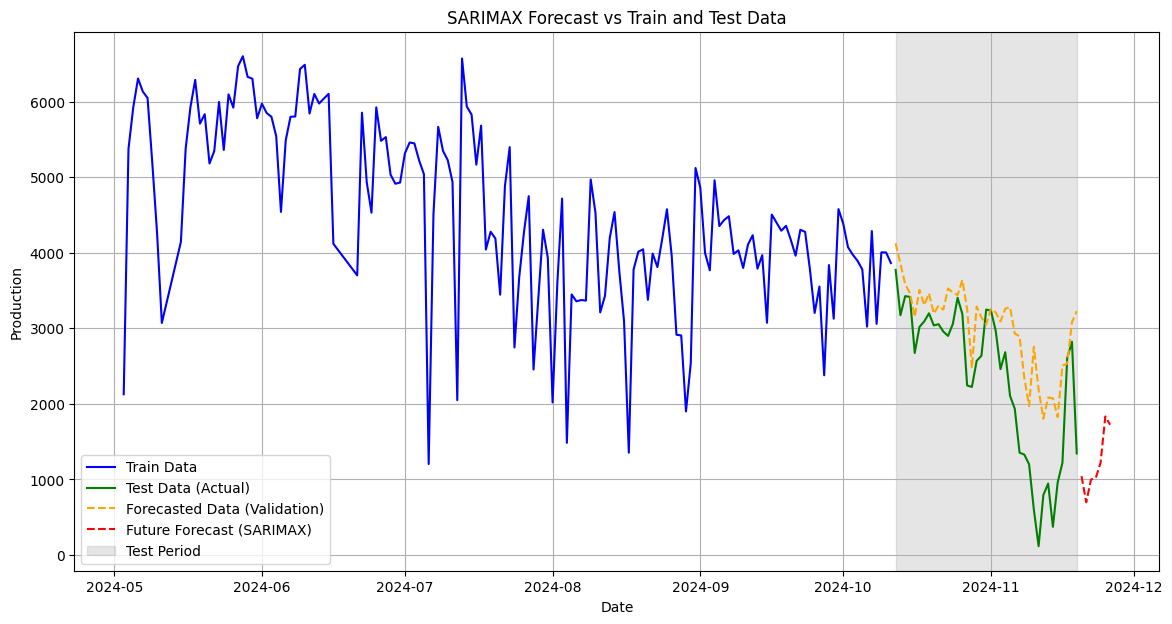

In [62]:
# Create a forecast index
forecast_index = pd.date_range(
    start=test.index[-1] + pd.Timedelta(days=1),  # Start after the test period
    periods=future_forecast_steps,
    freq='D'
)

# Create DataFrame for future forecast
future_forecast_df = pd.DataFrame({
    'date': forecast_index,
    'forecast': forecast_sarimax_future
}).set_index('date')

# Plot train data
plt.figure(figsize=(14, 7))
plt.plot(train['production'], label="Train Data", color='blue')

# Plot test data
plt.plot(test['production'], label="Test Data (Actual)", color='green')

# Plot test forecast
plt.plot(test.index, forecast_sarimax_test, label="Forecasted Data (Validation)", color='orange', linestyle='--')

# Plot future forecast
plt.plot(future_forecast_df.index, future_forecast_df['forecast'], label="Future Forecast (SARIMAX)", color='red', linestyle='--')

# Highlight the test period
plt.axvspan(test.index[0], test.index[-1], color='gray', alpha=0.2, label="Test Period")

plt.title("SARIMAX Forecast vs Train and Test Data")
plt.xlabel("Date")
plt.ylabel("Production")
plt.legend()
plt.grid(True)
plt.show()

# **Adding Variables from API**

In [63]:
def get_temp_from_api(date):
    try:
      url = "https://api.weatherapi.com/v1/history.json"

      params = {
          "key": "ce1ca5f45b0a44d28f4195047241912",
          "q": "faisalabad",
          "dt": date
      }

      response = requests.get(url, params=params)
      if response.status_code == 200:
          logging.info("API request successful.")
          return response.json()
      else:
          logging.error(f"API request failed with status code: {response.status_code}")
          return None
    except Exception as e:
        logging.error(f"Error occurred while fetching data from API: {e}")
        return None


def extract_temperatures(data):
    forecast_day = data['forecast']['forecastday'][0]['day']
    min_temp = forecast_day['mintemp_c']
    avg_temp = forecast_day['avgtemp_c']
    max_temp = forecast_day['maxtemp_c']
    condition = forecast_day['condition']['text']
    avg_humidity = forecast_day['avghumidity']
    uv = forecast_day['uv']
    moon_phase = data["forecast"]["forecastday"][0]["astro"]["moon_phase"]

    return max_temp, avg_temp, min_temp, condition, uv, avg_humidity, moon_phase

In [64]:
dates = preprocessed_df.index.to_list()

In [65]:
logging.info("Fetching Data from API STARTED.")

weather_data = {
    "date": [],
    "max_temp": [],
    "avg_temp": [],
    "min_temp": [],
    "moon_phase": [],
    "condition": [],
    "uv": [],
    "avg_humidity": []
}

for date in dates:
    weather_data["date"].append(date)
    try:
        response = get_temp_from_api(date)
        #print(response)
        max_temp, avg_temp, min_temp, condition, uv, avg_humidity, moon_phase = extract_temperatures(response)
        weather_data["max_temp"].append(max_temp)
        weather_data["avg_temp"].append(avg_temp)
        weather_data["min_temp"].append(min_temp)
        weather_data["moon_phase"].append(moon_phase)
        weather_data["condition"].append(condition)
        weather_data["avg_humidity"].append(avg_humidity)
        weather_data["uv"].append(uv)
        logging.info(f"Data for {date} fetched successfully.")
    except:
        weather_data["max_temp"].append(None)
        weather_data["avg_temp"].append(None)
        weather_data["min_temp"].append(None)
        weather_data["moon_phase"].append(None)
        weather_data["condition"].append(None)
        weather_data["avg_humidity"].append(None)
        weather_data["uv"].append(None)
        logging.info(f"Error occurred while fetching data for {date}.")

2024-12-28 13:07:33,558 - INFO - Fetching Data from API STARTED.
2024-12-28 13:07:33,566 - DEBUG - Starting new HTTPS connection (1): api.weatherapi.com:443
2024-12-28 13:07:33,744 - DEBUG - https://api.weatherapi.com:443 "GET /v1/history.json?key=ce1ca5f45b0a44d28f4195047241912&q=faisalabad&dt=2024-05-03+00%3A00%3A00 HTTP/11" 200 None
2024-12-28 13:07:33,749 - INFO - API request successful.
2024-12-28 13:07:33,752 - INFO - Data for 2024-05-03 00:00:00 fetched successfully.
2024-12-28 13:07:33,755 - DEBUG - Starting new HTTPS connection (1): api.weatherapi.com:443
2024-12-28 13:07:33,920 - DEBUG - https://api.weatherapi.com:443 "GET /v1/history.json?key=ce1ca5f45b0a44d28f4195047241912&q=faisalabad&dt=2024-05-04+00%3A00%3A00 HTTP/11" 200 None
2024-12-28 13:07:33,923 - INFO - API request successful.
2024-12-28 13:07:33,926 - INFO - Data for 2024-05-04 00:00:00 fetched successfully.
2024-12-28 13:07:33,930 - DEBUG - Starting new HTTPS connection (1): api.weatherapi.com:443
2024-12-28 13:0

**Converting Weather Data to DataFrame**

In [66]:
weather_df = pd.DataFrame(weather_data)
logging.info("Weather DataFrame created successfully.")
logging.info(weather_df.info())

2024-12-28 13:08:16,816 - INFO - Weather DataFrame created successfully.
2024-12-28 13:08:16,826 - INFO - None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 194 entries, 0 to 193
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          194 non-null    datetime64[ns]
 1   max_temp      194 non-null    float64       
 2   avg_temp      194 non-null    float64       
 3   min_temp      194 non-null    float64       
 4   moon_phase    194 non-null    object        
 5   condition     194 non-null    object        
 6   uv            194 non-null    float64       
 7   avg_humidity  194 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(2)
memory usage: 12.2+ KB


In [67]:
weather_df

,date,max_temp,avg_temp,min_temp,moon_phase,condition,uv,avg_humidity
0,2024-05-03,39.6,31.7,24.1,Waning Crescent,Partly cloudy,9.0,15
1,2024-05-04,39.6,32.9,26.0,Waning Crescent,Partly cloudy,9.0,20
2,2024-05-05,40.6,33.6,26.2,Waning Crescent,Sunny,10.0,21
3,2024-05-06,41.9,35.0,27.5,Waning Crescent,Sunny,10.0,19
4,2024-05-07,43.1,36.4,29.3,Waning Crescent,Sunny,10.0,16
...,...,...,...,...,...,...,...,...
189,2024-11-15,31.0,24.5,19.7,Waxing Gibbous,Sunny,8.0,29
190,2024-11-16,28.3,22.7,18.1,Full Moon,Sunny,7.0,44
191,2024-11-17,28.5,22.5,17.9,Waning Gibbous,Sunny,7.0,34
192,2024-11-18,28.7,22.2,17.4,Waning Gibbous,Partly cloudy,7.0,27


**Merging the data**

In [68]:
logging.info("Merging the data STARTED.")
result = pd.merge(preprocessed_df["production"], weather_df, how='left', on='date')
result

2024-12-28 13:08:16,892 - INFO - Merging the data STARTED.


,date,production,max_temp,avg_temp,min_temp,moon_phase,condition,uv,avg_humidity
0,2024-05-03,2127.6,39.6,31.7,24.1,Waning Crescent,Partly cloudy,9.0,15
1,2024-05-04,5377.3,39.6,32.9,26.0,Waning Crescent,Partly cloudy,9.0,20
2,2024-05-05,5924.9,40.6,33.6,26.2,Waning Crescent,Sunny,10.0,21
3,2024-05-06,6308.3,41.9,35.0,27.5,Waning Crescent,Sunny,10.0,19
4,2024-05-07,6135.8,43.1,36.4,29.3,Waning Crescent,Sunny,10.0,16
...,...,...,...,...,...,...,...,...,...
189,2024-11-15,959.6,31.0,24.5,19.7,Waxing Gibbous,Sunny,8.0,29
190,2024-11-16,1219.4,28.3,22.7,18.1,Full Moon,Sunny,7.0,44
191,2024-11-17,2606.5,28.5,22.5,17.9,Waning Gibbous,Sunny,7.0,34
192,2024-11-18,2822.9,28.7,22.2,17.4,Waning Gibbous,Partly cloudy,7.0,27


In [69]:
result.drop(columns=["moon_phase"], inplace=True)
result

,date,production,max_temp,avg_temp,min_temp,condition,uv,avg_humidity
0,2024-05-03,2127.6,39.6,31.7,24.1,Partly cloudy,9.0,15
1,2024-05-04,5377.3,39.6,32.9,26.0,Partly cloudy,9.0,20
2,2024-05-05,5924.9,40.6,33.6,26.2,Sunny,10.0,21
3,2024-05-06,6308.3,41.9,35.0,27.5,Sunny,10.0,19
4,2024-05-07,6135.8,43.1,36.4,29.3,Sunny,10.0,16
...,...,...,...,...,...,...,...,...
189,2024-11-15,959.6,31.0,24.5,19.7,Sunny,8.0,29
190,2024-11-16,1219.4,28.3,22.7,18.1,Sunny,7.0,44
191,2024-11-17,2606.5,28.5,22.5,17.9,Sunny,7.0,34
192,2024-11-18,2822.9,28.7,22.2,17.4,Partly cloudy,7.0,27


In [70]:
result = pd.get_dummies(result, columns=['condition'], drop_first=False)
logging.info("One-hot encoding completed successfully.")
result

2024-12-28 13:08:17,011 - INFO - One-hot encoding completed successfully.


,date,production,max_temp,avg_temp,min_temp,uv,avg_humidity,condition_Cloudy,condition_Light rain shower,condition_Moderate or heavy rain shower,condition_Overcast,condition_Partly cloudy,condition_Patchy light drizzle,condition_Patchy light rain,condition_Patchy light rain with thunder,condition_Patchy rain possible,condition_Sunny,condition_Thundery outbreaks possible
0,2024-05-03,2127.6,39.6,31.7,24.1,9.0,15,False,False,False,False,True,False,False,False,False,False,False
1,2024-05-04,5377.3,39.6,32.9,26.0,9.0,20,False,False,False,False,True,False,False,False,False,False,False
2,2024-05-05,5924.9,40.6,33.6,26.2,10.0,21,False,False,False,False,False,False,False,False,False,True,False
3,2024-05-06,6308.3,41.9,35.0,27.5,10.0,19,False,False,False,False,False,False,False,False,False,True,False
4,2024-05-07,6135.8,43.1,36.4,29.3,10.0,16,False,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,2024-11-15,959.6,31.0,24.5,19.7,8.0,29,False,False,False,False,False,False,False,False,False,True,False
190,2024-11-16,1219.4,28.3,22.7,18.1,7.0,44,False,False,False,False,False,False,False,False,False,True,False
191,2024-11-17,2606.5,28.5,22.5,17.9,7.0,34,False,False,False,False,False,False,False,False,False,True,False
192,2024-11-18,2822.9,28.7,22.2,17.4,7.0,27,False,False,False,False,True,False,False,False,False,False,False


**Converting Column to Datetime:**

In [71]:
result['date'] = pd.to_datetime(result['date'])
result.set_index('date', inplace=True)

In [72]:
result

,production,max_temp,avg_temp,min_temp,uv,avg_humidity,condition_Cloudy,condition_Light rain shower,condition_Moderate or heavy rain shower,condition_Overcast,condition_Partly cloudy,condition_Patchy light drizzle,condition_Patchy light rain,condition_Patchy light rain with thunder,condition_Patchy rain possible,condition_Sunny,condition_Thundery outbreaks possible
date,,,,,,,,,,,,,,,,,
2024-05-03,2127.6,39.6,31.7,24.1,9.0,15,False,False,False,False,True,False,False,False,False,False,False
2024-05-04,5377.3,39.6,32.9,26.0,9.0,20,False,False,False,False,True,False,False,False,False,False,False
2024-05-05,5924.9,40.6,33.6,26.2,10.0,21,False,False,False,False,False,False,False,False,False,True,False
2024-05-06,6308.3,41.9,35.0,27.5,10.0,19,False,False,False,False,False,False,False,False,False,True,False
2024-05-07,6135.8,43.1,36.4,29.3,10.0,16,False,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-15,959.6,31.0,24.5,19.7,8.0,29,False,False,False,False,False,False,False,False,False,True,False
2024-11-16,1219.4,28.3,22.7,18.1,7.0,44,False,False,False,False,False,False,False,False,False,True,False
2024-11-17,2606.5,28.5,22.5,17.9,7.0,34,False,False,False,False,False,False,False,False,False,True,False


In [73]:
result.columns.to_list()

['production',
 'max_temp',
 'avg_temp',
 'min_temp',
 'uv',
 'avg_humidity',
 'condition_Cloudy',
 'condition_Light rain shower',
 'condition_Moderate or heavy rain shower',
 'condition_Overcast',
 'condition_Partly cloudy',
 'condition_Patchy light drizzle',
 'condition_Patchy light rain',
 'condition_Patchy light rain with thunder',
 'condition_Patchy rain possible',
 'condition_Sunny',
 'condition_Thundery outbreaks possible']

In [74]:
bool_columns = [col for col in result.columns if result[col].dtype == 'bool']
result[bool_columns] = result[bool_columns].astype(int)
logging.info("Boolean columns converted to integers.")

2024-12-28 13:08:17,203 - INFO - Boolean columns converted to integers.


In [75]:
result.dropna(inplace=True)

**With adding new variables**

In [76]:
train_size = int(len(result) * 0.8)
train, test = result.iloc[:train_size], result.iloc[train_size:]
logging.info(f"Train Data Shape: {train.shape}")
logging.info(f"Test Data Shape: {test.shape}")

2024-12-28 13:10:38,277 - INFO - Train Data Shape: (155, 17)
2024-12-28 13:10:38,280 - INFO - Test Data Shape: (39, 17)


In [77]:
train

,production,max_temp,avg_temp,min_temp,uv,avg_humidity,condition_Cloudy,condition_Light rain shower,condition_Moderate or heavy rain shower,condition_Overcast,condition_Partly cloudy,condition_Patchy light drizzle,condition_Patchy light rain,condition_Patchy light rain with thunder,condition_Patchy rain possible,condition_Sunny,condition_Thundery outbreaks possible
date,,,,,,,,,,,,,,,,,
2024-05-03,2127.6,39.6,31.7,24.1,9.0,15,0,0,0,0,1,0,0,0,0,0,0
2024-05-04,5377.3,39.6,32.9,26.0,9.0,20,0,0,0,0,1,0,0,0,0,0,0
2024-05-05,5924.9,40.6,33.6,26.2,10.0,21,0,0,0,0,0,0,0,0,0,1,0
2024-05-06,6308.3,41.9,35.0,27.5,10.0,19,0,0,0,0,0,0,0,0,0,1,0
2024-05-07,6135.8,43.1,36.4,29.3,10.0,16,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-07,4287.7,40.1,32.6,25.9,10.0,28,0,0,0,0,0,0,0,0,0,1,0
2024-10-08,3059.1,37.3,30.8,25.9,9.0,36,0,0,0,0,1,0,0,0,0,0,0
2024-10-09,4006.1,37.8,30.3,25.5,8.0,35,0,0,0,0,0,0,0,0,1,0,0


In [78]:
y = train['production']
X_train = train[[
    'uv',
 'avg_temp',
 'avg_humidity',
 'condition_Cloudy',
 'condition_Light rain shower',
 'condition_Moderate or heavy rain shower',
 'condition_Overcast',
 'condition_Partly cloudy',
 'condition_Patchy light drizzle',
 'condition_Patchy light rain',
 'condition_Patchy light rain with thunder',
 'condition_Patchy rain possible',
 'condition_Sunny',
 'condition_Thundery outbreaks possible']]


In [79]:
logging.info(X_train.info())

2024-12-28 13:10:44,351 - INFO - None


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 155 entries, 2024-05-03 to 2024-10-11
Data columns (total 14 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   uv                                        155 non-null    float64
 1   avg_temp                                  155 non-null    float64
 2   avg_humidity                              155 non-null    int64  
 3   condition_Cloudy                          155 non-null    int64  
 4   condition_Light rain shower               155 non-null    int64  
 5   condition_Moderate or heavy rain shower   155 non-null    int64  
 6   condition_Overcast                        155 non-null    int64  
 7   condition_Partly cloudy                   155 non-null    int64  
 8   condition_Patchy light drizzle            155 non-null    int64  
 9   condition_Patchy light rain               155 non-null    int64  
 10  condition_Patchy li

As we have added new variables so now we are moving from univariate ARIMA to ARIMAX model which supports exogenous variables.

# **ARIMAX Model Training and Forecasting**

In [80]:
arimax_model = ARIMA(y, order=(best_p, best_d, best_q), exog=X_train)
arimax_model_fit = arimax_model.fit()

logging.info(arimax_model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
2024-12-28 13:10:53,887 - IN

In [81]:
logging.info("ARIMAX Model Validation STARTED.")


y_test = test['production']
X_test = test[[
 'uv',
 'avg_humidity',
 'avg_temp',
 'condition_Cloudy',
 'condition_Light rain shower',
 'condition_Moderate or heavy rain shower',
 'condition_Overcast',
 'condition_Partly cloudy',
 'condition_Patchy light drizzle',
 'condition_Patchy light rain',
 'condition_Patchy light rain with thunder',
 'condition_Patchy rain possible',
 'condition_Sunny',
 'condition_Thundery outbreaks possible']]



 # Forecast for validation
forecast_steps = len(test)
arimax_val_forecast = arimax_model_fit.forecast(steps=forecast_steps, exog=X_test)

logging.info("Validation Values:")
logging.info(arimax_val_forecast)

2024-12-28 13:10:56,987 - INFO - ARIMAX Model Validation STARTED.
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
2024-12-28 13:10:57,025 - INFO - Validation Values:
2024-12-28 13:10:57,032 - INFO - 155    3426.935807
156    3262.577522
157    3289.111086
158    3293.182522
159    3322.430377
160    3375.497507
161    3578.875347
162    3584.303928
163    3495.203217
164    3492.488927
165    3308.858925
166    3339.463925
167    3402.031071
168    3378.211797
169    3361.178249
170    3524.451073
171    3609.480348
172    3613.551783
173    3181.628541
174    3495.203217
175    3317.001796
176    3186.438924
177    2985.559702
178    2928.421137
179    3013.450412
180    3073.303268
181    3130.441833
182    3159.689688
183    3242.004672
184    3242.004672
185    3038.875962
186    3280.143204
187    

In [82]:
mae = mean_absolute_error(y_test, arimax_val_forecast)
mse = mean_squared_error(y_test, arimax_val_forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - arimax_val_forecast) / y_test)) * 100

logging.info(f"MAE: {mae}")
logging.info(f"RMSE: {rmse}")

<ipython-input-82-610e204ea32c>:4: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y_test - arimax_val_forecast) / y_test)) * 100
2024-12-28 13:11:01,465 - INFO - MAE: 965.1521458672531
2024-12-28 13:11:01,468 - INFO - RMSE: 1314.0795738702675


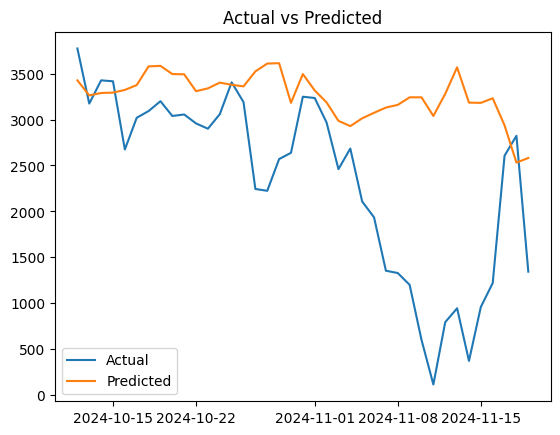

In [83]:
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, arimax_val_forecast, label='Predicted')
plt.legend()
plt.title("Actual vs Predicted")
plt.show()

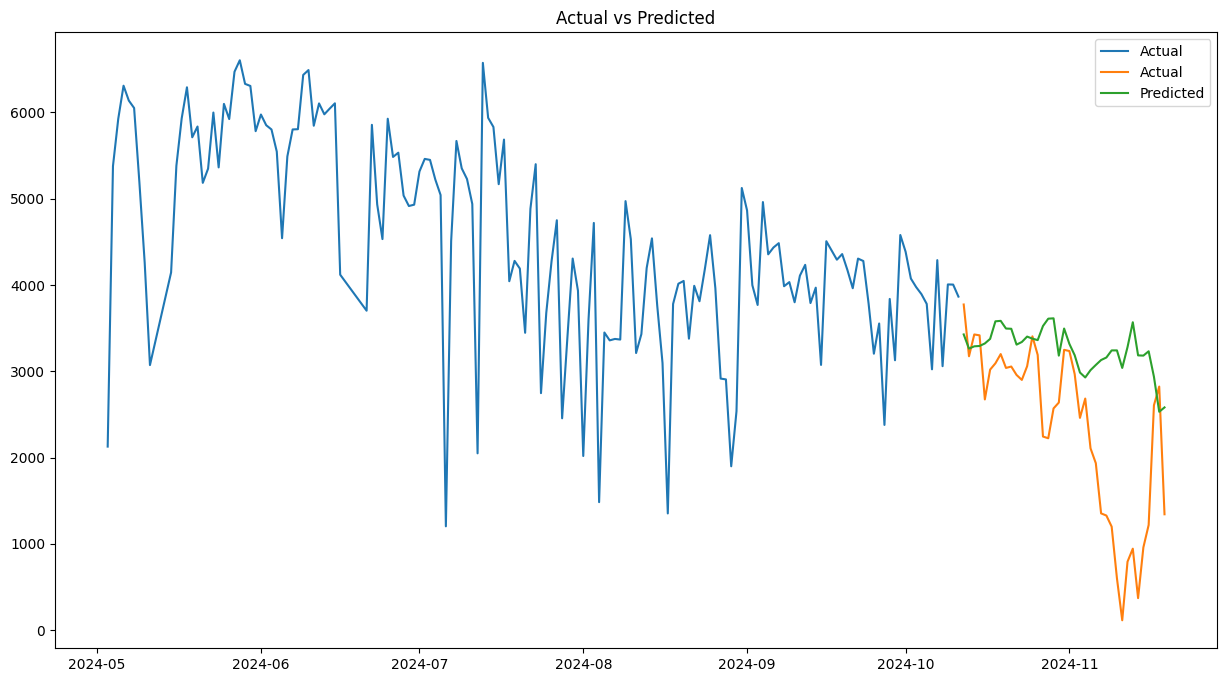

In [84]:
plt.figure(figsize=(15, 8))
plt.plot(X_train.index, y, label='Actual')
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, arimax_val_forecast, label='Predicted')
plt.legend()
plt.title("Actual vs Predicted")
plt.show()

# **SARIMAX Model Training and Forecasting**

In [85]:
sarimax_model = SARIMAX(
    y,
    exog=X_train,
    order=(best_p, best_d, best_q),
    seasonal_order=(best_P, best_D, best_Q, best_m)
)

sarimax_fit = sarimax_model.fit()

# Forecasting
forecast_steps = len(test)
val_forecast = sarimax_fit.forecast(steps=forecast_steps, exog=X_test)
logging.info(f"SARIMAX Validation Forecast: {val_forecast}")


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
2024-12-28 13:11:04,712 - INFO - SARIMAX Val

In [86]:
mae = mean_absolute_error(y_test, val_forecast)
mse = mean_squared_error(y_test, val_forecast)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - val_forecast) / y_test)) * 100

logging.info(f"MAE: {mae}")
logging.info(f"RMSE: {rmse}")

<ipython-input-86-bbda5d7aad40>:4: RuntimeWarning: '<' not supported between instances of 'int' and 'Timestamp', sort order is undefined for incomparable objects.
  mape = np.mean(np.abs((y_test - val_forecast) / y_test)) * 100
2024-12-28 13:11:04,739 - INFO - MAE: 976.2390065578938
2024-12-28 13:11:04,743 - INFO - RMSE: 1328.4751558736089


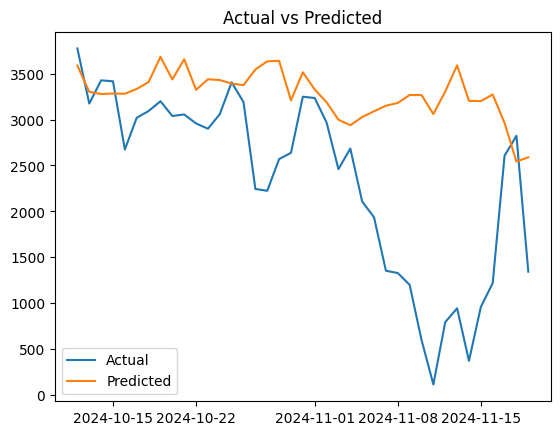

In [87]:
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, val_forecast, label='Predicted')
plt.legend()
plt.title("Actual vs Predicted")
plt.show()

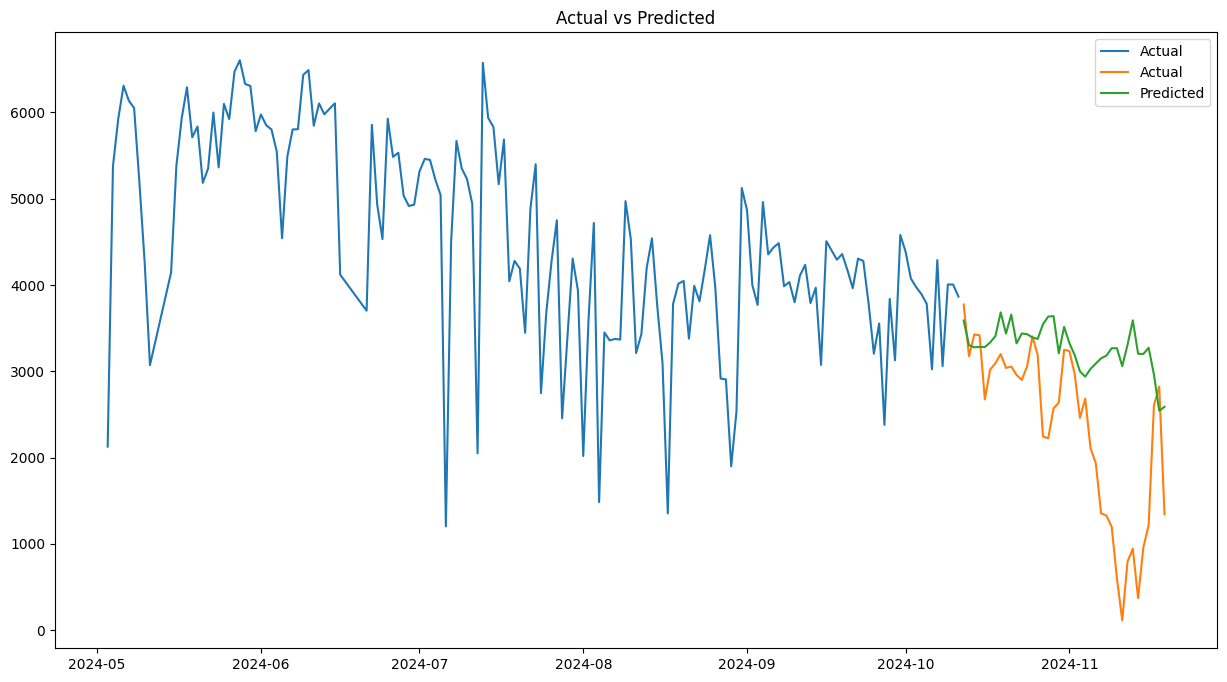

In [88]:
plt.figure(figsize=(15, 8))
plt.plot(X_train.index, y, label='Actual')
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, val_forecast, label='Predicted')
plt.legend()
plt.title("Actual vs Predicted")
plt.show()

# **Prophet Model**

In [89]:
%%capture
!pip install prophet

In [90]:
from prophet import Prophet

In [91]:
prophet_df = result[['production', 'avg_temp', 'avg_humidity', 'uv',
                     'condition_Cloudy', 'condition_Light rain shower', 'condition_Moderate or heavy rain shower',
                     'condition_Overcast', 'condition_Partly cloudy', 'condition_Patchy light drizzle',
                     'condition_Patchy light rain', 'condition_Patchy light rain with thunder',
                     'condition_Patchy rain possible', 'condition_Sunny', 'condition_Thundery outbreaks possible']].reset_index()

In [92]:
# Rename columns for Prophet compatibility
prophet_df = prophet_df.rename(columns={'date': 'ds', 'production': 'y'})
prophet_df

,ds,y,avg_temp,avg_humidity,uv,condition_Cloudy,condition_Light rain shower,condition_Moderate or heavy rain shower,condition_Overcast,condition_Partly cloudy,condition_Patchy light drizzle,condition_Patchy light rain,condition_Patchy light rain with thunder,condition_Patchy rain possible,condition_Sunny,condition_Thundery outbreaks possible
0,2024-05-03,2127.6,31.7,15,9.0,0,0,0,0,1,0,0,0,0,0,0
1,2024-05-04,5377.3,32.9,20,9.0,0,0,0,0,1,0,0,0,0,0,0
2,2024-05-05,5924.9,33.6,21,10.0,0,0,0,0,0,0,0,0,0,1,0
3,2024-05-06,6308.3,35.0,19,10.0,0,0,0,0,0,0,0,0,0,1,0
4,2024-05-07,6135.8,36.4,16,10.0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189,2024-11-15,959.6,24.5,29,8.0,0,0,0,0,0,0,0,0,0,1,0
190,2024-11-16,1219.4,22.7,44,7.0,0,0,0,0,0,0,0,0,0,1,0
191,2024-11-17,2606.5,22.5,34,7.0,0,0,0,0,0,0,0,0,0,1,0
192,2024-11-18,2822.9,22.2,27,7.0,0,0,0,0,1,0,0,0,0,0,0


In [93]:
# Split the data into train and test
train_size = int(len(prophet_df) * 0.8)
train, test = prophet_df.iloc[:train_size], prophet_df.iloc[train_size:]

In [94]:
# Initialize Prophet model and add external regressors
model = Prophet()

In [95]:
for col in ['avg_temp', 'avg_humidity', 'uv', 'condition_Cloudy', 'condition_Light rain shower',
            'condition_Moderate or heavy rain shower', 'condition_Overcast', 'condition_Partly cloudy',
            'condition_Patchy light drizzle', 'condition_Patchy light rain', 'condition_Patchy light rain with thunder',
            'condition_Patchy rain possible', 'condition_Sunny', 'condition_Thundery outbreaks possible']:
    model.add_regressor(col)

In [96]:
# Fit the model
model.fit(train)

2024-12-28 13:11:10,030 - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2024-12-28 13:11:10,032 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2024-12-28 13:11:10,085 - DEBUG - input tempfile: /tmp/tmpq057mi9_/qob8151c.json
2024-12-28 13:11:10,101 - DEBUG - input tempfile: /tmp/tmpq057mi9_/52wwshaw.json
2024-12-28 13:11:10,104 - DEBUG - idx 0
2024-12-28 13:11:10,107 - DEBUG - running CmdStan, num_threads: None
2024-12-28 13:11:10,109 - DEBUG - CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41520', 'data', 'file=/tmp/tmpq057mi9_/qob8151c.json', 'init=/tmp/tmpq057mi9_/52wwshaw.json', 'output', 'file=/tmp/tmpq057mi9_/prophet_model1sawt9qv/prophet_model-20241228131110.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:11:10 - cmdstanpy - INFO - Chain [1] start processing
2024-12-28 13:11:10,112 - INFO - Chain [1] start 

In [97]:
# Forecast for the test set
future = model.make_future_dataframe(periods=len(test))

In [98]:
# Add the weather regressors to the future dataframe (use test data for regressors)
for col in ['avg_temp', 'avg_humidity', 'uv', 'condition_Cloudy', 'condition_Light rain shower',
            'condition_Moderate or heavy rain shower', 'condition_Overcast', 'condition_Partly cloudy',
            'condition_Patchy light drizzle', 'condition_Patchy light rain', 'condition_Patchy light rain with thunder',
            'condition_Patchy rain possible', 'condition_Sunny', 'condition_Thundery outbreaks possible']:
    future[col] = pd.concat([train[col], test[col]], axis=0).reset_index(drop=True)

In [99]:
# Make predictions
forecast = model.predict(future)

In [100]:
# Extract predicted values and actual test values
y_true = test['y'].values
y_pred = forecast[-len(test):]['yhat'].values

In [101]:
# Evaluate the model
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)

In [102]:
logging.info(f"Mean Squared Error (RMSE): {rmse}")
logging.info(f"Mean Absolute Error (MAE): {mae}")

2024-12-28 13:11:10,465 - INFO - Mean Squared Error (RMSE): 1437.1182252515089
2024-12-28 13:11:10,468 - INFO - Mean Absolute Error (MAE): 1118.0542687569994


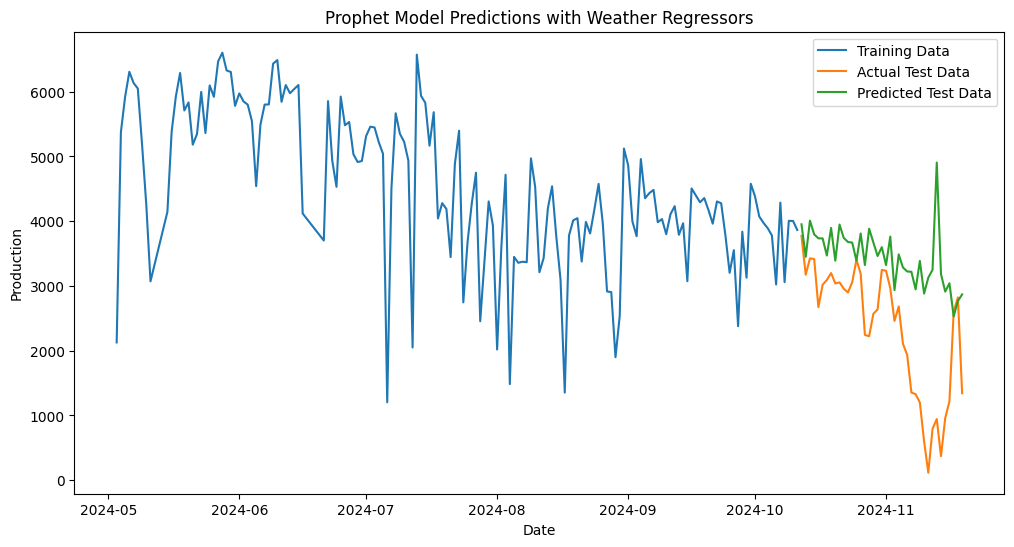

In [103]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train['ds'], train['y'], label='Training Data')
plt.plot(test['ds'], test['y'], label='Actual Test Data')
plt.plot(forecast['ds'][-len(test):], forecast['yhat'][-len(test):], label='Predicted Test Data')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Production')
plt.title('Prophet Model Predictions with Weather Regressors')
plt.show()

# **Prophet Model - Hyperparameter Tuning**

In [104]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import logging

In [105]:
prophet_df = result[['production', 'avg_temp', 'avg_humidity', 'uv',
                     'condition_Cloudy', 'condition_Light rain shower', 'condition_Moderate or heavy rain shower',
                     'condition_Overcast', 'condition_Partly cloudy', 'condition_Patchy light drizzle',
                     'condition_Patchy light rain', 'condition_Patchy light rain with thunder',
                     'condition_Patchy rain possible', 'condition_Sunny', 'condition_Thundery outbreaks possible']].reset_index()

In [106]:
prophet_df = prophet_df.rename(columns={'date': 'ds', 'production': 'y'})

In [107]:
train_size = int(len(prophet_df) * 0.8)
train, test = prophet_df.iloc[:train_size], prophet_df.iloc[train_size:]

In [108]:
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 1.0, 10.0]
}

In [109]:
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

In [110]:
regressors = ['avg_temp', 'avg_humidity', 'uv', 'condition_Cloudy', 'condition_Light rain shower',
              'condition_Moderate or heavy rain shower', 'condition_Overcast', 'condition_Partly cloudy',
              'condition_Patchy light drizzle', 'condition_Patchy light rain',
              'condition_Patchy light rain with thunder', 'condition_Patchy rain possible',
              'condition_Sunny', 'condition_Thundery outbreaks possible']

In [111]:
best_params = None
best_rmse = float('inf')

In [112]:
for params in all_params:
    logging.info(f"Testing parameters: {params}")
    model = Prophet(**params)
    for col in regressors:
        model.add_regressor(col)

    # Fit the model
    model.fit(train)

    # Create future dataframe and add regressors
    future = model.make_future_dataframe(periods=len(test))
    for col in regressors:
        future[col] = pd.concat([train[col], test[col]], axis=0).reset_index(drop=True)

    # Make predictions
    forecast = model.predict(future)

    # Extract predicted values and actual test values
    y_true = test['y'].values
    y_pred = forecast[-len(test):]['yhat'].values

    # Evaluate the model
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    logging.info(f"RMSE for parameters {params}: {rmse}")

    # Update best parameters if current MSE is lower
    if rmse < best_rmse:
        best_params = params
        best_rmse = rmse

2024-12-28 13:11:11,229 - INFO - Testing parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
2024-12-28 13:11:11,251 - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2024-12-28 13:11:11,252 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2024-12-28 13:11:11,277 - DEBUG - input tempfile: /tmp/tmpq057mi9_/g4dprbij.json
2024-12-28 13:11:11,289 - DEBUG - input tempfile: /tmp/tmpq057mi9_/bo4kb_fd.json
2024-12-28 13:11:11,292 - DEBUG - idx 0
2024-12-28 13:11:11,293 - DEBUG - running CmdStan, num_threads: None
2024-12-28 13:11:11,296 - DEBUG - CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38132', 'data', 'file=/tmp/tmpq057mi9_/g4dprbij.json', 'init=/tmp/tmpq057mi9_/bo4kb_fd.json', 'output', 'file=/tmp/tmpq057mi9_/prophet_model5eylj9jk/prophet_model-20241228131111.csv', 'metho

In [113]:
logging.info(f"Best Parameters: {best_params}")
logging.info(f"Best RMSE: {best_rmse}")

2024-12-28 13:11:17,354 - INFO - Best Parameters: {'seasonality_mode': 'multiplicative', 'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01}
2024-12-28 13:11:17,359 - INFO - Best RMSE: 930.6904668737366


In [114]:
final_model = Prophet(**best_params)
for col in regressors:
    final_model.add_regressor(col)
final_model.fit(train)

2024-12-28 13:11:17,460 - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2024-12-28 13:11:17,468 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2024-12-28 13:11:17,522 - DEBUG - input tempfile: /tmp/tmpq057mi9_/9xjp0w7y.json
2024-12-28 13:11:17,546 - DEBUG - input tempfile: /tmp/tmpq057mi9_/w3swksod.json
2024-12-28 13:11:17,552 - DEBUG - idx 0
2024-12-28 13:11:17,557 - DEBUG - running CmdStan, num_threads: None
2024-12-28 13:11:17,559 - DEBUG - CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31171', 'data', 'file=/tmp/tmpq057mi9_/9xjp0w7y.json', 'init=/tmp/tmpq057mi9_/w3swksod.json', 'output', 'file=/tmp/tmpq057mi9_/prophet_model8a1k5s_y/prophet_model-20241228131117.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:11:17 - cmdstanpy - INFO - Chain [1] start processing
2024-12-28 13:11:17,561 - INFO - Chain [1] start 

In [115]:
future = final_model.make_future_dataframe(periods=len(test))
for col in regressors:
    future[col] = pd.concat([train[col], test[col]], axis=0).reset_index(drop=True)
forecast = final_model.predict(future)

In [116]:
y_true = test['y'].values
y_pred = forecast[-len(test):]['yhat'].values

In [117]:
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mse)
logging.info(f"Final Mean Squared Error (RMSE): {rmse}")
logging.info(f"Final Mean Absolute Error (MAE): {mae}")

2024-12-28 13:11:17,992 - INFO - Final Mean Squared Error (RMSE): 930.6904668737366
2024-12-28 13:11:18,001 - INFO - Final Mean Absolute Error (MAE): 705.9843223591296


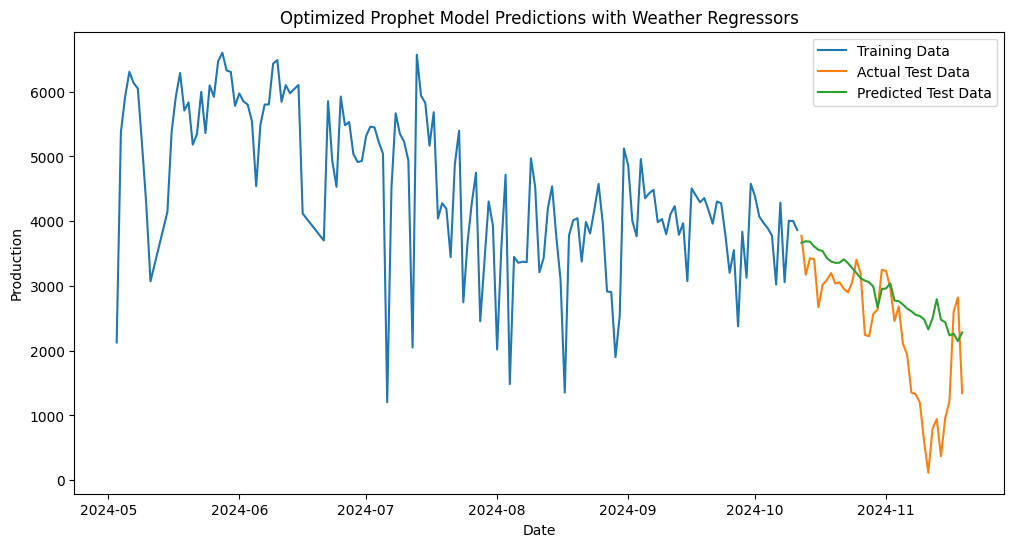

In [118]:
plt.figure(figsize=(12, 6))
plt.plot(train['ds'], train['y'], label='Training Data')
plt.plot(test['ds'], test['y'], label='Actual Test Data')
plt.plot(forecast['ds'][-len(test):], forecast['yhat'][-len(test):], label='Predicted Test Data')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Production')
plt.title('Optimized Prophet Model Predictions with Weather Regressors')
plt.show()

# **New Tasks**

# **Prophet without Weather Data**

In [119]:
# Prepare the dataset without weather data
prophet_df2 = prophet_df.rename(columns={'date': 'ds', 'production': 'y'})

In [120]:
# Split the data into train and test
train_size = int(len(prophet_df2) * 0.8)
train, test = prophet_df2.iloc[:train_size], prophet_df2.iloc[train_size:]

In [121]:
# Define parameter grid for hypertuning
param_grid = {
    'seasonality_mode': ['additive', 'multiplicative'],
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 1.0, 10.0]
}

In [122]:
# Generate all parameter combinations
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

In [123]:
best_params = None
best_rmse = float('inf')

In [124]:
# Hypertuning
for params in all_params:
    logging.info(f"Testing parameters: {params}")
    model = Prophet(**params)

    # Fit the model
    model.fit(train)

    # Create future dataframe
    future = model.make_future_dataframe(periods=len(test))

    # Make predictions
    forecast = model.predict(future)

    # Extract predicted values and actual test values
    y_true = test['y'].values
    y_pred = forecast[-len(test):]['yhat'].values

    # Evaluate the model
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    logging.info(f"RMSE for parameters {params}: {rmse}")

    # Update best parameters if current MSE is lower
    if rmse < best_rmse:
        best_params = params
        best_rmse = rmse

2024-12-28 13:11:18,774 - INFO - Testing parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
2024-12-28 13:11:18,804 - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2024-12-28 13:11:18,809 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2024-12-28 13:11:18,839 - DEBUG - input tempfile: /tmp/tmpq057mi9_/we0nwfq3.json
2024-12-28 13:11:18,862 - DEBUG - input tempfile: /tmp/tmpq057mi9_/g6kb_nb8.json
2024-12-28 13:11:18,870 - DEBUG - idx 0
2024-12-28 13:11:18,874 - DEBUG - running CmdStan, num_threads: None
2024-12-28 13:11:18,880 - DEBUG - CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50341', 'data', 'file=/tmp/tmpq057mi9_/we0nwfq3.json', 'init=/tmp/tmpq057mi9_/g6kb_nb8.json', 'output', 'file=/tmp/tmpq057mi9_/prophet_modelbfivo_h9/prophet_model-20241228131118.csv', 'metho

In [125]:
logging.info(f"Best Parameters: {best_params}")
logging.info(f"Best MSE: {best_rmse}")

2024-12-28 13:11:26,455 - INFO - Best Parameters: {'seasonality_mode': 'additive', 'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01}
2024-12-28 13:11:26,513 - INFO - Best MSE: 1122.2008955114743


In [126]:
# Train final model with best parameters
final_model = Prophet(**best_params)
final_model.fit(train)

2024-12-28 13:11:26,632 - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2024-12-28 13:11:26,636 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2024-12-28 13:11:26,683 - DEBUG - input tempfile: /tmp/tmpq057mi9_/545qi86k.json
2024-12-28 13:11:26,701 - DEBUG - input tempfile: /tmp/tmpq057mi9_/y_s23mnk.json
2024-12-28 13:11:26,711 - DEBUG - idx 0
2024-12-28 13:11:26,716 - DEBUG - running CmdStan, num_threads: None
2024-12-28 13:11:26,719 - DEBUG - CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74476', 'data', 'file=/tmp/tmpq057mi9_/545qi86k.json', 'init=/tmp/tmpq057mi9_/y_s23mnk.json', 'output', 'file=/tmp/tmpq057mi9_/prophet_model_31b44q5/prophet_model-20241228131126.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:11:26 - cmdstanpy - INFO - Chain [1] start processing
2024-12-28 13:11:26,724 - INFO - Chain [1] start 

In [127]:
# Create future dataframe and make predictions
future = final_model.make_future_dataframe(periods=len(test))
forecast = final_model.predict(future)

In [128]:
# Evaluate the final model
y_true = test['y'].values
y_pred = forecast[-len(test):]['yhat'].values

In [129]:
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
logging.info(f"Final Root Mean Squared Error (RMSE): {rmse}")
logging.info(f"Final Mean Absolute Error (MAE): {mae}")

2024-12-28 13:11:27,063 - INFO - Final Root Mean Squared Error (RMSE): 1122.2008955114743
2024-12-28 13:11:27,066 - INFO - Final Mean Absolute Error (MAE): 791.1902716432136


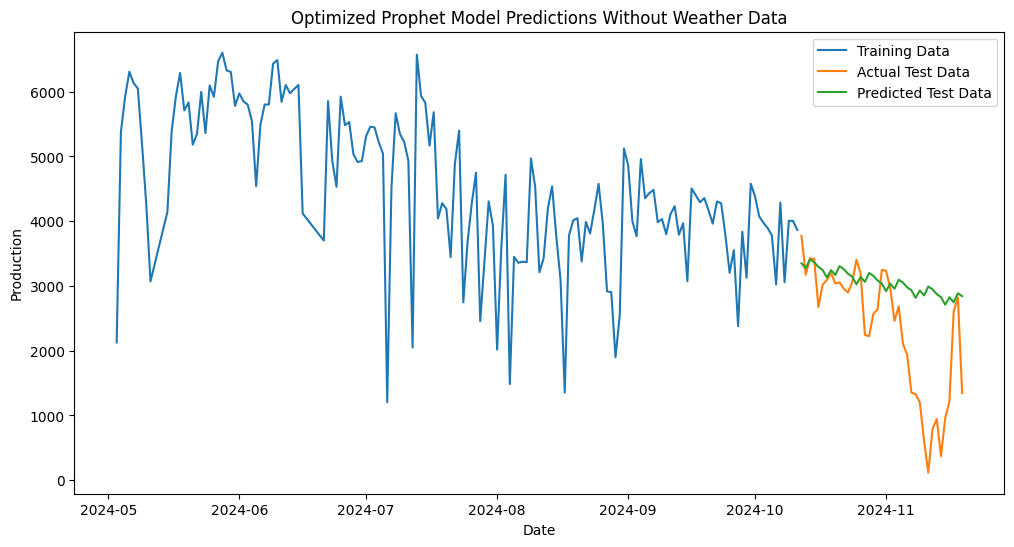

In [130]:
# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train['ds'], train['y'], label='Training Data')
plt.plot(test['ds'], test['y'], label='Actual Test Data')
plt.plot(forecast['ds'][-len(test):], forecast['yhat'][-len(test):], label='Predicted Test Data')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Production')
plt.title('Optimized Prophet Model Predictions Without Weather Data')
plt.show()

# **Different Forecasting Window**

In [131]:
forecast_window = 30

# Split data into train and test based on forecasting window
train = prophet_df2.iloc[:-forecast_window]  # Exclude the last `forecast_window` rows
test = prophet_df2.iloc[-forecast_window:]  # Use the last `forecast_window` rows for testing

In [132]:
# Initialize Prophet model
model = Prophet()

# Fit the model on training data
model.fit(train)

# Create a future dataframe with the forecasting window
future = model.make_future_dataframe(periods=forecast_window)

# Make predictions
forecast = model.predict(future)

2024-12-28 13:11:28,093 - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2024-12-28 13:11:28,096 - INFO - Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
2024-12-28 13:11:28,134 - DEBUG - input tempfile: /tmp/tmpq057mi9_/7tnloonk.json
2024-12-28 13:11:28,145 - DEBUG - input tempfile: /tmp/tmpq057mi9_/ehnxment.json
2024-12-28 13:11:28,149 - DEBUG - idx 0
2024-12-28 13:11:28,151 - DEBUG - running CmdStan, num_threads: None
2024-12-28 13:11:28,154 - DEBUG - CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=70105', 'data', 'file=/tmp/tmpq057mi9_/7tnloonk.json', 'init=/tmp/tmpq057mi9_/ehnxment.json', 'output', 'file=/tmp/tmpq057mi9_/prophet_model7wc_g5oz/prophet_model-20241228131128.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
13:11:28 - cmdstanpy - INFO - Chain [1] start processing
2024-12-28 13:11:28,156 - INFO - Chain [1] start 

2024-12-28 13:11:28,544 - INFO - Root Mean Squared Error (RMSE): 1324.1537310866383
2024-12-28 13:11:28,547 - INFO - Mean Absolute Error (MAE): 1045.5167569431242


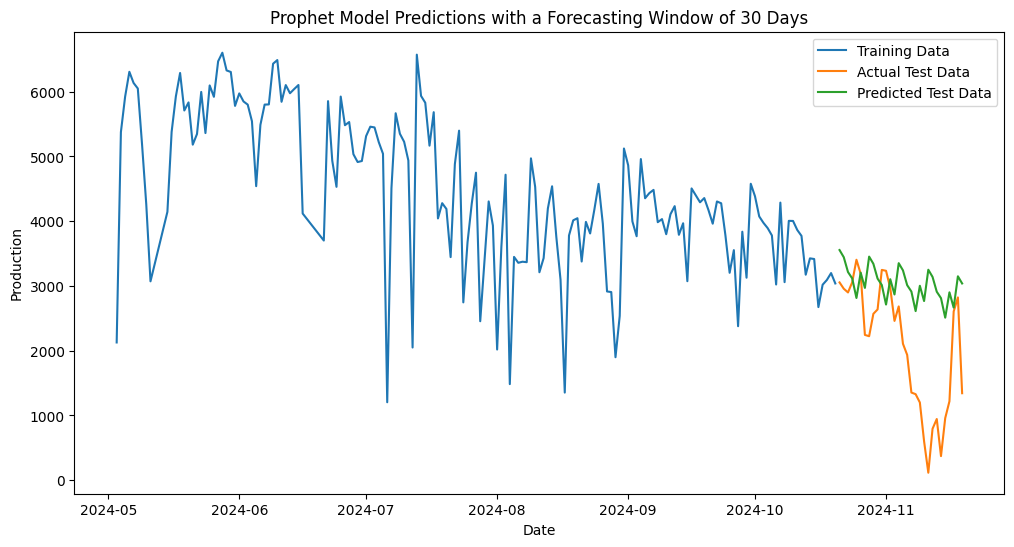

In [133]:
# Evaluate the model
y_true = test['y'].values
y_pred = forecast['yhat'][-forecast_window:].values

# Calculate evaluation metrics
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

# Logging results
logging.info(f"Root Mean Squared Error (RMSE): {rmse}")
logging.info(f"Mean Absolute Error (MAE): {mae}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(train['ds'], train['y'], label='Training Data')
plt.plot(test['ds'], test['y'], label='Actual Test Data')
plt.plot(forecast['ds'][-forecast_window:], forecast['yhat'][-forecast_window:], label='Predicted Test Data')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Production')
plt.title(f'Prophet Model Predictions with a Forecasting Window of {forecast_window} Days')
plt.show()

# **Use the fitted model to predict for a different month**

2024-12-28 13:11:47,795 - INFO - Train Data Shape: (155, 17)
2024-12-28 13:11:47,797 - INFO - Test Data Shape: (39, 17)
2024-12-28 13:11:47,803 - INFO - Starting SARIMAX model training and testing for forecast window: 7 days
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/t

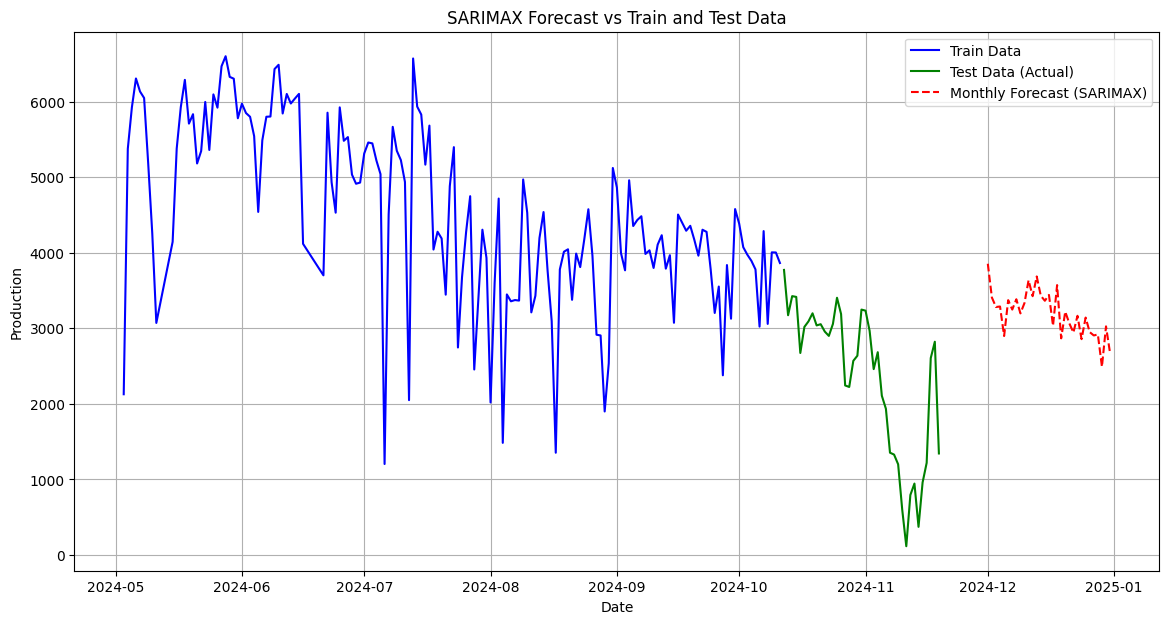

In [134]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO)

# Example DataFrame `result` (Assuming `result` is preprocessed and has the required columns)
# Replace this with your actual DataFrame
# result = your_preprocessed_dataframe

# Train-test split
train_size = int(len(result) * 0.8)
train, test = result.iloc[:train_size], result.iloc[train_size:]

logging.info(f"Train Data Shape: {train.shape}")
logging.info(f"Test Data Shape: {test.shape}")

# Define y_train and y_test
y_train = train['production']
y_test = test['production']

# Define X_train and X_test (exogenous variables)
X_train = train[[
    'uv',
    'avg_temp',
    'avg_humidity',
    'condition_Cloudy',
    'condition_Light rain shower',
    'condition_Moderate or heavy rain shower',
    'condition_Overcast',
    'condition_Partly cloudy',
    'condition_Patchy light drizzle',
    'condition_Patchy light rain',
    'condition_Patchy light rain with thunder',
    'condition_Patchy rain possible',
    'condition_Sunny',
    'condition_Thundery outbreaks possible'
]]

X_test = test[[
    'uv',
    'avg_temp',
    'avg_humidity',
    'condition_Cloudy',
    'condition_Light rain shower',
    'condition_Moderate or heavy rain shower',
    'condition_Overcast',
    'condition_Partly cloudy',
    'condition_Patchy light drizzle',
    'condition_Patchy light rain',
    'condition_Patchy light rain with thunder',
    'condition_Patchy rain possible',
    'condition_Sunny',
    'condition_Thundery outbreaks possible'
]]

# Loop through different forecast windows
forecast_windows = [7, 14, 21, 28]  # Example forecast windows in days

for window in forecast_windows:
    logging.info(f"Starting SARIMAX model training and testing for forecast window: {window} days")

    # Train SARIMAX model with exogenous variables
    sarimax_model = SARIMAX(
        y_train,
        exog=X_train,  # Training exogenous variables
        order=(1, 1, 1),  # Example (p, d, q)
        seasonal_order=(1, 1, 1, 12)  # Example (P, D, Q, m)
    )
    sarimax_fitted = sarimax_model.fit(disp=False)

    # Validate on Test Data
    forecast_sarimax_test = sarimax_fitted.forecast(
        steps=window,  # Current forecast window
        exog=X_test.iloc[:window]  # Corresponding exogenous test variables
    )
    logging.info(f"SARIMAX Validation Forecast for {window} days: {forecast_sarimax_test}")

    # Evaluate performance
    mae = mean_absolute_error(y_test.iloc[:window], forecast_sarimax_test)
    rmse = mean_squared_error(y_test.iloc[:window], forecast_sarimax_test)
    logging.info(f"Performance for window {window} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# Forecast for a specific month
month_start_date = '2024-12-01'  # Example start date for May 2024
month_end_date = '2024-12-31'  # Example end date for May 2024
forecast_steps_month = (pd.to_datetime(month_end_date) - pd.to_datetime(month_start_date)).days + 1

sarimax_model_full = SARIMAX(
    y_train,
    exog=X_train,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12)
)
sarimax_fitted_full = sarimax_model_full.fit(disp=False)

forecast_sarimax_month = sarimax_fitted_full.forecast(
    steps=forecast_steps_month,
    exog=X_test.iloc[:forecast_steps_month]  # Exogenous data for the specific month
)

# Create a forecast index for the month
forecast_index_month = pd.date_range(
    start=month_start_date,
    periods=forecast_steps_month,
    freq='D'
)

# Create DataFrame for the monthly forecast
monthly_forecast_df = pd.DataFrame({
    'date': forecast_index_month,
    'forecast': forecast_sarimax_month
}).set_index('date')

# Log the forecast
logging.info(f"SARIMAX Forecast for {month_start_date} to {month_end_date}: {monthly_forecast_df}")

# Plotting
plt.figure(figsize=(14, 7))

# Plot train data (Use the index of train data)
plt.plot(y_train.index, y_train, label="Train Data", color='blue')

# Plot test data (Use the index of test data)
plt.plot(y_test.index, y_test, label="Test Data (Actual)", color='green')

# Plot monthly forecast
plt.plot(monthly_forecast_df.index, monthly_forecast_df['forecast'], label="Monthly Forecast (SARIMAX)", color='red', linestyle='--')

plt.title("SARIMAX Forecast vs Train and Test Data")
plt.xlabel("Date")
plt.ylabel("Production")
plt.legend()
plt.grid(True)
plt.show()


# **Regression Models**

In [135]:
result.head(5)

,production,max_temp,avg_temp,min_temp,uv,avg_humidity,condition_Cloudy,condition_Light rain shower,condition_Moderate or heavy rain shower,condition_Overcast,condition_Partly cloudy,condition_Patchy light drizzle,condition_Patchy light rain,condition_Patchy light rain with thunder,condition_Patchy rain possible,condition_Sunny,condition_Thundery outbreaks possible
date,,,,,,,,,,,,,,,,,
2024-05-03,2127.6,39.6,31.7,24.1,9.0,15,0,0,0,0,1,0,0,0,0,0,0
2024-05-04,5377.3,39.6,32.9,26.0,9.0,20,0,0,0,0,1,0,0,0,0,0,0
2024-05-05,5924.9,40.6,33.6,26.2,10.0,21,0,0,0,0,0,0,0,0,0,1,0
2024-05-06,6308.3,41.9,35.0,27.5,10.0,19,0,0,0,0,0,0,0,0,0,1,0
2024-05-07,6135.8,43.1,36.4,29.3,10.0,16,0,0,0,0,0,0,0,0,0,1,0


In [136]:
logging.info("Trying Regression Models Now!")

2024-12-28 13:12:28,257 - INFO - Trying Regression Models Now!


In [137]:
# Ensure the date column is the index, and the data is sorted chronologically (As time series dataset)

# Ensure 'date' is the index
result.index = pd.to_datetime(result.index)

# Sort the data by date
result = result.sort_index()

**Feature Engineering**

In [138]:
logging.info("Create lag features to provide the model with historical data for predictions.")

for lag in range(1, 8):  # Lag of 1 to 7 days
    result[f'lag_{lag}'] = result['production'].shift(lag)


logging.info("Add rolling averages or moving statistics.")
result['rolling_mean_7d'] = result['production'].rolling(window=7).mean()

2024-12-28 13:12:28,277 - INFO - Create lag features to provide the model with historical data for predictions.
2024-12-28 13:12:28,283 - INFO - Add rolling averages or moving statistics.


In [139]:
result = result.dropna()

**time-based splitting**

In [140]:
logging.info("Use a time-based split to avoid data leakage.")
train_size = int(0.7 * len(result))
train = result.iloc[:train_size]
test = result.iloc[train_size:]


features = [col for col in result.columns if col not in ['production']]
X_train, y_train = train[features], train['production']
X_test, y_test = test[features], test['production']

2024-12-28 13:12:28,303 - INFO - Use a time-based split to avoid data leakage.


**RandomForestRegressor**

**Model Training and Evaluation**

In [141]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Initialize and train the model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
# Compute Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
logging.info("Root Mean Squared Error: %s", rmse)

# Compute Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)
logging.info("Mean Absolute Error: %s", mae)

2024-12-28 13:12:28,949 - INFO - Root Mean Squared Error: 1225.06776779418
2024-12-28 13:12:28,953 - INFO - Mean Absolute Error: 958.2304561403109


**Cross-Validation**

In [142]:
from sklearn.model_selection import TimeSeriesSplit
import numpy as np

tscv = TimeSeriesSplit(n_splits=5)

mae_scores = []
rmse_scores = []
for train_index, test_index in tscv.split(result):
    X_train, X_test = result.iloc[train_index][features], result.iloc[test_index][features]
    y_train, y_test = result.iloc[train_index]['production'], result.iloc[test_index]['production']

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    mae_scores.append(mean_absolute_error(y_test, y_pred))


avg_rmse = np.mean(rmse_scores)
avg_mae = np.mean(mae_scores)

# Log the results
logging.info("Cross-validated Root Mean Squared Error: %s", avg_rmse)
logging.info("Cross-validated Mean Absolute Error: %s", avg_mae)

2024-12-28 13:12:30,129 - INFO - Cross-validated Root Mean Squared Error: 1044.792677630909
2024-12-28 13:12:30,131 - INFO - Cross-validated Mean Absolute Error: 785.5819548387028


**Linear Regression**

In [143]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()

tscv = TimeSeriesSplit(n_splits=5)

linear_rmse_scores = []
linear_mae_scores = []

for train_index, test_index in tscv.split(result):
    X_train, X_test = result.iloc[train_index][features], result.iloc[test_index][features]
    y_train, y_test = result.iloc[train_index]['production'], result.iloc[test_index]['production']

    linear_model.fit(X_train, y_train)
    y_pred = linear_model.predict(X_test)

    linear_rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    linear_mae_scores.append(mean_absolute_error(y_test, y_pred))


logging.info("Linear Regression Cross-validated RMSE: %s", np.mean(linear_rmse_scores))
logging.info("Linear Regression Cross-validated MAE: %s", np.mean(linear_mae_scores))

2024-12-28 13:12:30,194 - INFO - Linear Regression Cross-validated RMSE: 7.471954775102537e-12
2024-12-28 13:12:30,195 - INFO - Linear Regression Cross-validated MAE: 6.4222061360675475e-12


**Decision Tree Regressor**

In [144]:
from sklearn.tree import DecisionTreeRegressor

# Initialize the Decision Tree Regressor
tree_model = DecisionTreeRegressor(random_state=42)

tree_rmse_scores = []
tree_mae_scores = []

for train_index, test_index in tscv.split(result):
    X_train, X_test = result.iloc[train_index][features], result.iloc[test_index][features]
    y_train, y_test = result.iloc[train_index]['production'], result.iloc[test_index]['production']

    tree_model.fit(X_train, y_train)
    y_pred = tree_model.predict(X_test)

    tree_rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
    tree_mae_scores.append(mean_absolute_error(y_test, y_pred))

# Log results
logging.info("Decision Tree Regressor Cross-validated RMSE: %s", np.mean(tree_rmse_scores))
logging.info("Decision Tree Regressor Cross-validated MAE: %s", np.mean(tree_mae_scores))


2024-12-28 13:12:30,264 - INFO - Decision Tree Regressor Cross-validated RMSE: 1343.1094871901066
2024-12-28 13:12:30,265 - INFO - Decision Tree Regressor Cross-validated MAE: 1078.4270967741527


# **Regression Models with New Weather Data**

In [145]:
%%capture
!pip install meteostat

**Adding New Weather Data**

In [146]:
from meteostat import Point, Daily
from datetime import datetime
import requests
import pandas as pd


logging.info("Adding New Weather Data")

# Location (Faisalabad)
location = Point(31.4504, 73.1350)

# Date range
start = datetime(2024, 5, 1)
end = datetime(2024, 12, 26)

# Get Meteostat daily weather data
meteostat_data = Daily(location, start, end).fetch()

# Fetch solar radiation data from Open-Meteo
try:
  open_meteo_url = (
      "https://archive-api.open-meteo.com/v1/era5?"
      "latitude=31.4504&longitude=73.1350&"
      "start_date=2024-05-01&end_date=2024-05-31&"
      "daily=shortwave_radiation_sum&timezone=Asia/Karachi"
  )
  response = requests.get(open_meteo_url)
  solar_data = response.json()
  logging.info("Successfully fetched solar radiation data from Open-Meteo.")
except Exception as e:
  logging.error(f"Error fetching solar radiation data from Open-Meteo: {e}")


# Extract solar radiation data
radiation_data = pd.DataFrame(solar_data["daily"])
radiation_data["time"] = pd.to_datetime(radiation_data["time"])
radiation_data.set_index("time", inplace=True)

# Combine datasets
combined_data = meteostat_data.join(radiation_data["shortwave_radiation_sum"])
combined_data

2024-12-28 13:12:34,871 - INFO - Adding New Weather Data
2024-12-28 13:12:36,614 - DEBUG - Starting new HTTPS connection (1): archive-api.open-meteo.com:443
2024-12-28 13:12:36,997 - DEBUG - https://archive-api.open-meteo.com:443 "GET /v1/era5?latitude=31.4504&longitude=73.1350&start_date=2024-05-01&end_date=2024-05-31&daily=shortwave_radiation_sum&timezone=Asia/Karachi HTTP/11" 200 None
2024-12-28 13:12:36,999 - INFO - Successfully fetched solar radiation data from Open-Meteo.


,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun,shortwave_radiation_sum
time,,,,,,,,,,,
2024-05-01,23.0,14.6,30.7,0.0,NaN,332.0,10.9,NaN,1005.2,NaN,24.82
2024-05-02,26.7,16.5,35.0,0.0,NaN,332.0,6.4,NaN,1005.4,NaN,25.11
2024-05-03,28.6,20.1,37.4,0.0,NaN,115.0,8.7,NaN,1005.2,NaN,14.54
2024-05-04,29.5,22.9,37.0,0.0,NaN,16.0,12.0,NaN,1006.7,NaN,21.91
2024-05-05,30.6,22.7,38.4,0.0,NaN,324.0,8.5,NaN,1003.4,NaN,23.64
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-22,12.5,7.7,19.1,0.0,NaN,135.0,4.0,NaN,1015.4,NaN,NaN
2024-12-23,12.0,8.2,16.9,0.1,NaN,80.0,9.1,NaN,1016.5,NaN,NaN
2024-12-24,11.9,6.8,18.3,0.0,NaN,335.0,6.0,NaN,1018.9,NaN,NaN


In [147]:
logging.info("Drop unnecessary columns")

# Drop unnecessary columns
columns_to_drop = ['tsun', 'wpgt', 'snow']
combined_data = combined_data.drop(columns=columns_to_drop)
combined_data

2024-12-28 13:12:41,011 - INFO - Drop unnecessary columns


,tavg,tmin,tmax,prcp,wdir,wspd,pres,shortwave_radiation_sum
time,,,,,,,,
2024-05-01,23.0,14.6,30.7,0.0,332.0,10.9,1005.2,24.82
2024-05-02,26.7,16.5,35.0,0.0,332.0,6.4,1005.4,25.11
2024-05-03,28.6,20.1,37.4,0.0,115.0,8.7,1005.2,14.54
2024-05-04,29.5,22.9,37.0,0.0,16.0,12.0,1006.7,21.91
2024-05-05,30.6,22.7,38.4,0.0,324.0,8.5,1003.4,23.64
...,...,...,...,...,...,...,...,...
2024-12-22,12.5,7.7,19.1,0.0,135.0,4.0,1015.4,NaN
2024-12-23,12.0,8.2,16.9,0.1,80.0,9.1,1016.5,NaN
2024-12-24,11.9,6.8,18.3,0.0,335.0,6.0,1018.9,NaN


In [148]:
# Rename the index if 'time' is an index
combined_data.index.rename('date', inplace=True)
combined_data

,tavg,tmin,tmax,prcp,wdir,wspd,pres,shortwave_radiation_sum
date,,,,,,,,
2024-05-01,23.0,14.6,30.7,0.0,332.0,10.9,1005.2,24.82
2024-05-02,26.7,16.5,35.0,0.0,332.0,6.4,1005.4,25.11
2024-05-03,28.6,20.1,37.4,0.0,115.0,8.7,1005.2,14.54
2024-05-04,29.5,22.9,37.0,0.0,16.0,12.0,1006.7,21.91
2024-05-05,30.6,22.7,38.4,0.0,324.0,8.5,1003.4,23.64
...,...,...,...,...,...,...,...,...
2024-12-22,12.5,7.7,19.1,0.0,135.0,4.0,1015.4,NaN
2024-12-23,12.0,8.2,16.9,0.1,80.0,9.1,1016.5,NaN
2024-12-24,11.9,6.8,18.3,0.0,335.0,6.0,1018.9,NaN


In [149]:
preprocessed_df

,production,production_diff,production_log,production_log_diff,seasonal_diff
date,,,,,
2024-05-03,2127.6,NaN,7.662750,NaN,NaN
2024-05-04,5377.3,3249.7,8.589942,0.927192,NaN
2024-05-05,5924.9,547.6,8.686919,0.096977,NaN
2024-05-06,6308.3,383.4,8.749622,0.062702,NaN
2024-05-07,6135.8,-172.5,8.721896,-0.027726,NaN
...,...,...,...,...,...
2024-11-15,959.6,587.4,6.866517,0.947085,-1500.6
2024-11-16,1219.4,259.8,7.106114,0.239598,-1464.8
2024-11-17,2606.5,1387.1,7.865764,0.759649,498.8


In [150]:
# Add lag feature for production_log BEFORE merging or splitting
preprocessed_df['production_log_lag1'] = preprocessed_df['production_log'].shift(1)

# Merge the lagged production_log with the weather data
#selected_scaled_column = preprocessed_df[['production_log', 'production_log_lag1']]

# Ensuring weather data does not include future values
#aligned_weather_data = combined_data.loc[:preprocessed_df.index.max()]

# Re-merge aligned weather data
#merged_data = aligned_weather_data.merge(selected_scaled_column, left_index=True, right_index=True, how='inner')

# Fill NaN values caused by lag features
#merged_data['production_log_lag1'] = merged_data['production_log_lag1'].fillna(method='bfill')

In [151]:
# Merge the production log with weather data (no lagged features)
merged_data = combined_data.loc[:preprocessed_df.index.max()].merge(
    preprocessed_df[['production_log']],
    left_index=True,
    right_index=True,
    how='inner'
)

**Import necessary libraries**

In [152]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt

In [153]:
# Drop rows with missing values
logging.info("Drop rows with missing values")
merged_data.dropna()

2024-12-28 13:12:43,241 - INFO - Drop rows with missing values


,tavg,tmin,tmax,prcp,wdir,wspd,pres,shortwave_radiation_sum,production_log
date,,,,,,,,,
2024-05-03,28.6,20.1,37.4,0.0,115.0,8.7,1005.2,14.54,7.662750
2024-05-04,29.5,22.9,37.0,0.0,16.0,12.0,1006.7,21.91,8.589942
2024-05-05,30.6,22.7,38.4,0.0,324.0,8.5,1003.4,23.64,8.686919
2024-05-06,32.4,24.0,40.4,0.0,3.0,7.6,1003.2,24.23,8.749622
2024-05-07,33.7,24.5,41.6,0.0,22.0,7.7,1004.4,24.67,8.721896
2024-05-08,34.2,24.8,43.3,0.0,42.0,7.6,1003.7,24.57,8.707847
2024-05-09,34.1,26.3,43.5,0.0,123.0,11.8,1002.6,23.90,8.554277
2024-05-10,32.6,22.0,41.5,0.0,66.0,16.3,1004.6,20.57,8.357306
2024-05-11,30.2,22.0,39.2,3.2,296.0,9.3,1007.6,21.93,8.030084


**Splitting Dataset**

In [154]:
# Separate features (X) and target (y)
#X = cleaned_data.drop(columns=['production_log'], errors='ignore')
#y = cleaned_data['production_log']

In [155]:
# 80% train, 20% test
logging.info("Splitting Dataset")
split_index = int(len(merged_data) * 0.8)
train_data = merged_data.iloc[:split_index]
test_data = merged_data.iloc[split_index:]

# Separate features and targets
X_train = train_data.drop(columns=['production_log'], errors='ignore')
y_train = train_data['production_log']
X_test = test_data.drop(columns=['production_log'], errors='ignore')
y_test = test_data['production_log']

2024-12-28 13:12:44,002 - INFO - Splitting Dataset


**Scaling Dataset**

In [156]:
logging.info("Scaling Data")

from sklearn.preprocessing import StandardScaler
# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler only on the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

2024-12-28 13:12:44,666 - INFO - Scaling Data


**Initialize Model Training**

In [157]:
# Initialize and train the Random Forest Regressor
logging.info("Initialize Model Training")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

2024-12-28 13:12:45,807 - INFO - Initialize Model Training


RandomForestRegressor(random_state=42)

In [158]:
# Make predictions on the test set
logging.info("Make Predictions")
y_pred = rf_model.predict(X_test)

# Calculate evaluation metrics
logging.info("Calculate Evaluation Metrics")
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
#r2 = r2_score(y_test, y_pred)

# Print the performance metrics
logging.info(f"Root Mean Squared Error (RMSE): {rmse}")
logging.info(f"Mean Absolute Error (MAE): {mae}")
logging.info(f"R-squared (R²): {r2}")

2024-12-28 13:12:46,249 - INFO - Make Predictions
2024-12-28 13:12:46,278 - INFO - Calculate Evaluation Metrics
2024-12-28 13:12:46,284 - INFO - Root Mean Squared Error (RMSE): 0.8319402725770885
2024-12-28 13:12:46,286 - INFO - Mean Absolute Error (MAE): 0.520998161000045


NameError: name 'r2' is not defined

**Visualization**

In [ ]:
logging.info("Plot Actual vs. Predicted Values")
# Plot actual vs. predicted values for the test set
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label="Actual Test Values", marker='o', linestyle='-', alpha=0.7)
plt.plot(y_pred, label="Predicted Test Values", marker='x', linestyle='--', alpha=0.7)

# Label the plot
plt.title("Test Set: Actual vs Predicted Solar Production Log")
plt.xlabel("Sample Index")
plt.ylabel("Solar Production Log")
plt.legend()
plt.show()


2024-12-28 13:12:47,118 - INFO - Plot Feature Importance


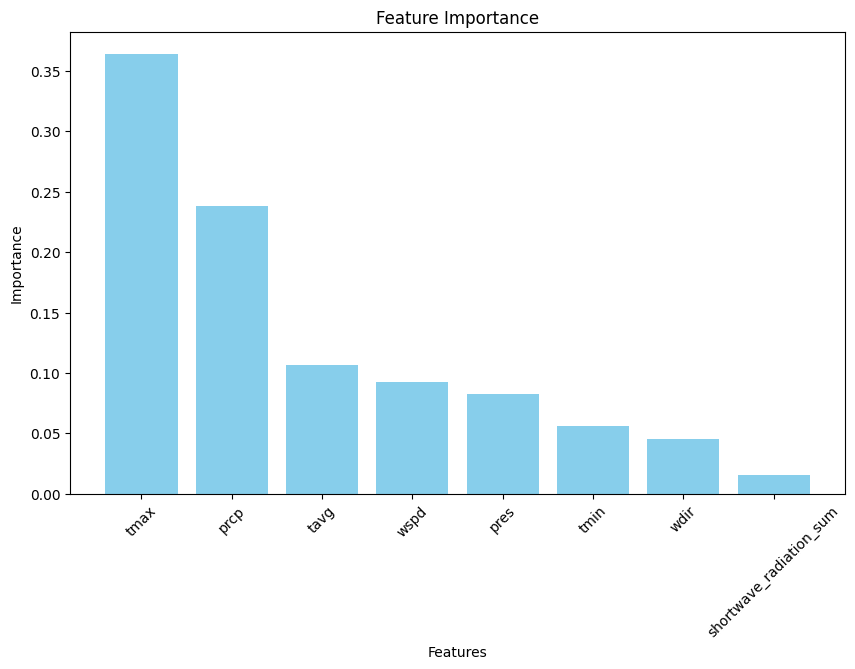

In [159]:
# Plot feature importance
logging.info("Plot Feature Importance")

cleaned_data = merged_data.dropna()

# Separate features (X) and target (y)
X = cleaned_data.drop(columns=['production_log'], errors='ignore')  # Features (weather data)
y = cleaned_data['production_log']  # Target (scaled solar production)


feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['Feature'], feature_importance['Importance'], color='skyblue')
plt.title("Feature Importance")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=45)
plt.show()


In [160]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# Perform grid search
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train_scaled, y_train)

# Use the best model
best_rf_model = grid_search.best_estimator_
logging.info("Best Parameters:", grid_search.best_params_)

# Train and test the best model
y_pred = best_rf_model.predict(X_test_scaled)

# Evaluate the optimized model
mae = mean_absolute_error(y_test, y_pred)
logging.info(f"Optimized Model - Mean Absolute Error (MAE): {mae}")

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
logging.info(f"Optimized Model - Root Mean Squared Error (RMSE): {rmse}")
#r2 = r2_score(y_test, y_pred)
#logging.info(f"Optimized Model - Mean Squared Error (MSE): {mse}")
#logging.info(f"Optimized Model - R-squared (R²): {r2}")


2024-12-28 13:14:18,813 - INFO - Best Parameters:
2024-12-28 13:14:18,844 - INFO - Optimized Model - Mean Absolute Error (MAE): 0.500791097106416
2024-12-28 13:14:18,848 - INFO - Optimized Model - Root Mean Squared Error (RMSE): 0.819627753813548


In [161]:
from sklearn.model_selection import TimeSeriesSplit

# Initialize time-series cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# Evaluate model using time-series cross-validation
for train_index, test_index in tscv.split(X_train):
    X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

    # Train model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train_cv, y_train_cv)

    # Evaluate
    y_pred_cv = rf_model.predict(X_test_cv)
    logging.info("Mean Absolute Error: %s", mean_absolute_error(y_test_cv, y_pred_cv))
    logging.info("Root Mean Squared Error: %s", np.sqrt(mean_squared_error(y_test_cv, y_pred_cv)))


2024-12-28 13:14:19,021 - INFO - Mean Absolute Error: 0.11259630775308786
2024-12-28 13:14:19,023 - INFO - Root Mean Squared Error: 0.152267187954863
2024-12-28 13:14:19,202 - INFO - Mean Absolute Error: 0.2591835074203541
2024-12-28 13:14:19,207 - INFO - Root Mean Squared Error: 0.38766678894000955
2024-12-28 13:14:19,385 - INFO - Mean Absolute Error: 0.24787280505603865
2024-12-28 13:14:19,389 - INFO - Root Mean Squared Error: 0.3278040259261776
2024-12-28 13:14:19,616 - INFO - Mean Absolute Error: 0.23599023307481404
2024-12-28 13:14:19,619 - INFO - Root Mean Squared Error: 0.3454780303431164
2024-12-28 13:14:19,826 - INFO - Mean Absolute Error: 0.22201313834710587
2024-12-28 13:14:19,829 - INFO - Root Mean Squared Error: 0.2924032033700905


In [162]:
# Make predictions using the best model
y_pred_best = best_rf_model.predict(X_test)

# Evaluate the performance
mae_best = mean_absolute_error(y_test, y_pred_best)
logging.info(f"Optimized Random Forest - Mean Absolute Error (MAE): {mae_best}")

mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
#r2_best = r2_score(y_test, y_pred_best)

logging.info(f"Optimized Random Forest - Root Mean Squared Error (RMSE): {rmse_best}")


2024-12-28 13:14:19,883 - INFO - Optimized Random Forest - Mean Absolute Error (MAE): 0.8311416674670272
2024-12-28 13:14:19,886 - INFO - Optimized Random Forest - Root Mean Squared Error (RMSE): 1.0912302487476235


In [163]:
from xgboost import XGBRegressor

# Train an XGBoost Regressor
xgb_model = XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the performance
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
#r2_xgb = r2_score(y_test, y_pred_xgb)

logging.info(f"XGBoost - Mean Absolute Error (MAE): {mae_xgb}")
logging.info(f"XGBoost - Root Mean Squared Error (RMSE): {rmse_xgb}")
#logging.info(f"XGBoost - R-squared (R²): {r2_xgb}")


2024-12-28 13:14:20,311 - INFO - XGBoost - Mean Absolute Error (MAE): 0.5904715998701292
2024-12-28 13:14:20,316 - INFO - XGBoost - Root Mean Squared Error (RMSE): 0.9141164444587153


In [164]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

# Cross-validate the best Random Forest model
cv_scores = cross_val_score(best_rf_model, X, y, cv=5, scoring='r2')
logging.info(f"Cross-validated R² scores: {cv_scores}")
logging.info(f"Mean R²: {cv_scores.mean()}")

# Calculate additional metrics on the test set
mae = mean_absolute_error(y_test, y_pred_best)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
#mape = (abs(y_test - y_pred_best) / y_test).mean() * 100

logging.info(f"Mean Absolute Error (MAE): {mae}")
logging.info(f"Root Mean Squared Error (RMSE): {rmse}")
#logging.info(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


2024-12-28 13:14:22,485 - INFO - Cross-validated R² scores: [ 0.02281501 -1.10750625 -0.70965511 -0.85113728 -5.057556  ]
2024-12-28 13:14:22,487 - INFO - Mean R²: -1.5406079255070857
2024-12-28 13:14:22,492 - INFO - Mean Absolute Error (MAE): 0.8311416674670272
2024-12-28 13:14:22,495 - INFO - Root Mean Squared Error (RMSE): 1.0912302487476235


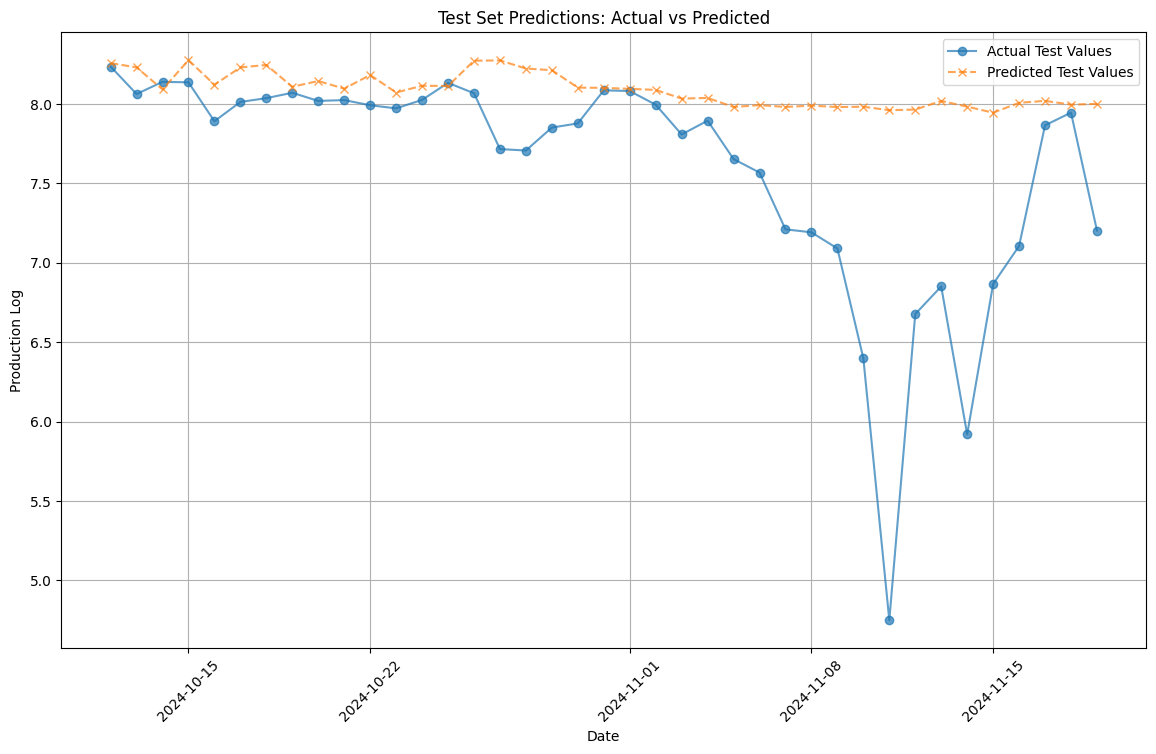

In [165]:
# Predict on the test set
y_test_pred = best_rf_model.predict(X_test_scaled)

# Combine test predictions and actual values into a DataFrame
test_results = pd.DataFrame({
    'Date': X_test.index,  # Dates corresponding to the test set
    'Actual': y_test,
    'Predicted': y_test_pred
})

# Plot the actual and predicted values for the test set
plt.figure(figsize=(14, 8))
plt.plot(test_results['Date'], test_results['Actual'], label="Actual Test Values", marker='o', linestyle='-', alpha=0.7)
plt.plot(test_results['Date'], test_results['Predicted'], label="Predicted Test Values", marker='x', linestyle='--', alpha=0.7)

# Label the plot
plt.title("Test Set Predictions: Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Production Log")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


2024-12-28 13:14:22,982 - DEBUG - Starting new HTTPS connection (1): archive-api.open-meteo.com:443
2024-12-28 13:14:23,368 - DEBUG - https://archive-api.open-meteo.com:443 "GET /v1/era5?latitude=31.4504&longitude=73.1350&start_date=2024-11-20&end_date=2024-11-26&daily=shortwave_radiation_sum&timezone=Asia/Karachi HTTP/11" 200 None
2024-12-28 13:14:23,424 - INFO -         Date  Predicted (Scaled)  Predicted (Actual)
0 2024-11-20            7.975472         2908.731567
1 2024-11-21            7.968812         2889.421780
2 2024-11-22            7.957807         2857.797913
3 2024-11-23            7.955102         2850.080271
4 2024-11-24            7.922342         2758.224160
5 2024-11-25            7.961429         2868.167260
6 2024-11-26            7.992818         2959.623980


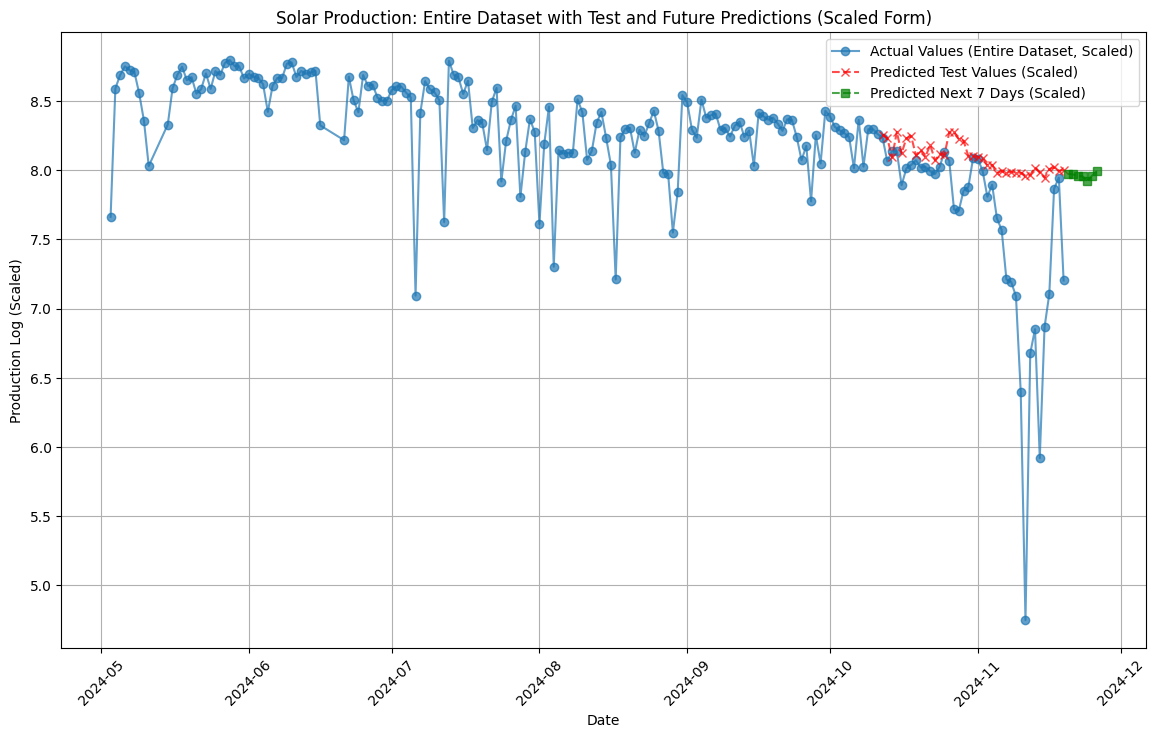

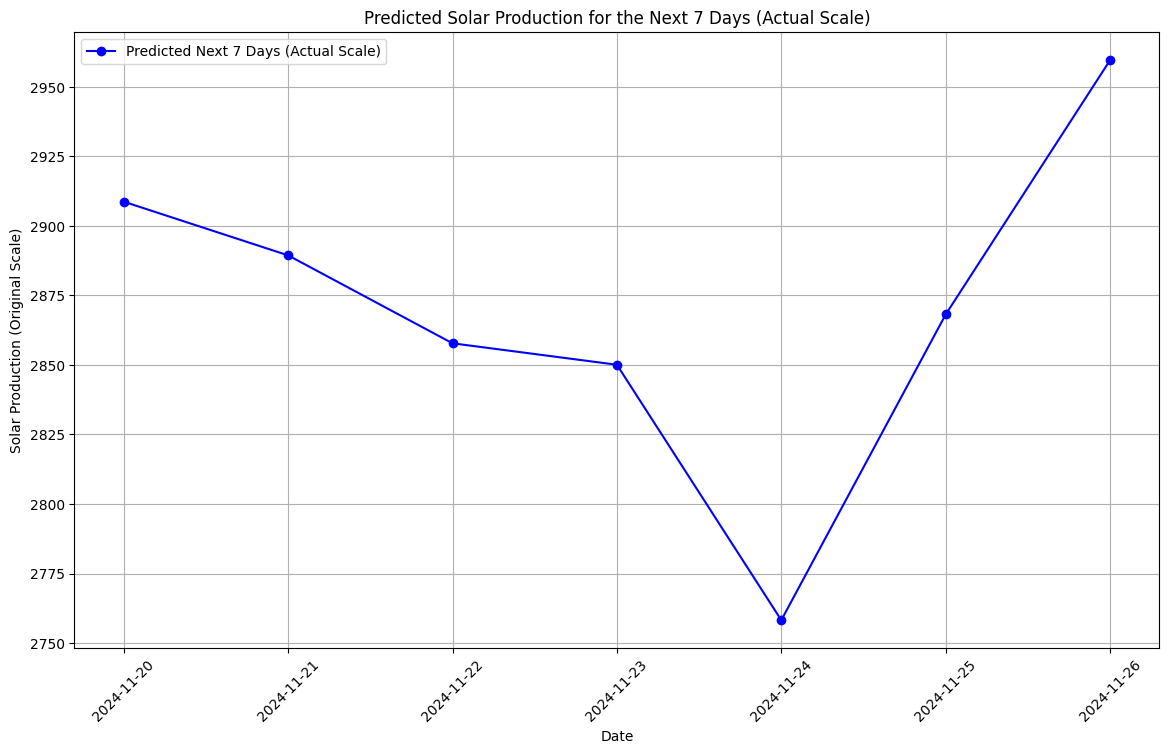

In [166]:
# Predict on the test set only (scaled form)
y_test_pred_scaled = best_rf_model.predict(X_test_scaled)

# Combine test predictions with actual values into a DataFrame
test_results_scaled = pd.DataFrame({
    'Date': X_test.index,  # Dates corresponding to the test set
    'Actual (Scaled)': y_test,  # Already log-transformed
    'Predicted (Scaled)': y_test_pred_scaled
})

# Combine entire dataset for actual values
all_actual_results = pd.DataFrame({
    'Date': merged_data.index,
    'Actual': merged_data['production_log']  # Already in scaled (log) form
})

# ------------------------------------
# Predict Next 7 Days Values (Scaled Form)
# ------------------------------------
from meteostat import Point, Daily
from datetime import datetime
import requests

# Location (Faisalabad)
location = Point(31.4504, 73.1350)

# Define the date range for the next 7 days
start = datetime(2024, 11, 20)  # Start date for future weather data
end = datetime(2024, 11, 26)    # End date for future weather data

# Fetch Meteostat daily weather data for the next 7 days
meteostat_future_data = Daily(location, start, end).fetch()

# Fetch solar radiation data from Open-Meteo for the next 7 days
open_meteo_url = (
    f"https://archive-api.open-meteo.com/v1/era5?"
    f"latitude=31.4504&longitude=73.1350&"
    f"start_date={start.strftime('%Y-%m-%d')}&end_date={end.strftime('%Y-%m-%d')}&"
    f"daily=shortwave_radiation_sum&timezone=Asia/Karachi"
)
response = requests.get(open_meteo_url)
solar_data = response.json()

# Extract solar radiation data
radiation_data = pd.DataFrame(solar_data["daily"])
radiation_data["time"] = pd.to_datetime(radiation_data["time"])
radiation_data.set_index("time", inplace=True)

# Combine Meteostat and Open-Meteo data
future_weather_data = meteostat_future_data.join(radiation_data["shortwave_radiation_sum"])

# Drop unnecessary columns
columns_to_drop = ['tsun', 'wpgt', 'snow']
future_weather_data = future_weather_data.drop(columns=columns_to_drop, errors='ignore')

# Add the last known production_log value for lag feature
last_production_log = merged_data['production_log'].iloc[-1]
future_weather_data['production_log_lag1'] = last_production_log  # Use the last known value as lag

# Ensure future_weather_data columns match the training features
training_features = X_train.columns  # Columns used during training
future_weather_data = future_weather_data[training_features]

# Fill missing values
future_weather_data.fillna(method='ffill', inplace=True)

# Scale the future weather data using the same scaler
future_features_scaled = scaler.transform(future_weather_data)

# Predict solar production for the next 7 days (in scaled form)
future_predictions_scaled = best_rf_model.predict(future_features_scaled)

# ------------------------------------
# Reverse Log Transformation for Final Predictions
# ------------------------------------
# Convert log-transformed predictions back to original scale
future_predictions_actual = np.exp(future_predictions_scaled)

# Combine future dates with predictions
future_results = pd.DataFrame({
    'Date': future_weather_data.index,
    'Predicted (Scaled)': future_predictions_scaled,
    'Predicted (Actual)': future_predictions_actual
})

# Display the next 7 days of predictions
logging.info(future_results)

# ------------------------------------
# Plot All Results (Train, Test, and Future Predictions)
# ------------------------------------

plt.figure(figsize=(14, 8))

# Plot the actual values for the entire dataset
plt.plot(all_actual_results['Date'], all_actual_results['Actual'], label="Actual Values (Entire Dataset, Scaled)", marker='o', linestyle='-', alpha=0.7)

# Overlay the predicted values only for the test dataset (scaled)
plt.plot(test_results_scaled['Date'], test_results_scaled['Predicted (Scaled)'], label="Predicted Test Values (Scaled)", marker='x', linestyle='--', alpha=0.7, color='red')

# Overlay the predicted values for the next 7 days (scaled)
plt.plot(future_results['Date'], future_results['Predicted (Scaled)'], label="Predicted Next 7 Days (Scaled)", marker='s', linestyle='--', alpha=0.7, color='green')

# Label the plot
plt.title("Solar Production: Entire Dataset with Test and Future Predictions (Scaled Form)")
plt.xlabel("Date")
plt.ylabel("Production Log (Scaled)")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

# Plot for Actual Scale (Optional)
plt.figure(figsize=(14, 8))
plt.plot(future_results['Date'], future_results['Predicted (Actual)'], label="Predicted Next 7 Days (Actual Scale)", marker='o', linestyle='-', color='blue')
plt.title("Predicted Solar Production for the Next 7 Days (Actual Scale)")
plt.xlabel("Date")
plt.ylabel("Solar Production (Original Scale)")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()


**Convert Values in actual form**

In [167]:
import numpy as np

# Reverse the logarithmic transformation on predicted values
y_test_pred_actual = np.exp(y_test_pred)

# Reverse the logarithmic transformation on actual values
y_test_actual = np.exp(y_test)

# Combine dates, actual, and predicted values into a DataFrame
test_results_actual = pd.DataFrame({
    'Date': X_test.index,  # Dates corresponding to the test set
    'Actual': y_test_actual,
    'Predicted': y_test_pred_actual
})

# Display the actual and predicted values in their original form
logging.info(test_results_actual)


2024-12-28 13:14:24,344 - INFO -                  Date  Actual    Predicted
date                                      
2024-10-12 2024-10-12  3773.7  3855.578769
2024-10-13 2024-10-13  3173.9  3753.586822
2024-10-14 2024-10-14  3426.6  3266.668075
2024-10-15 2024-10-15  3416.5  3927.985307
2024-10-16 2024-10-16  2674.1  3365.939129
2024-10-17 2024-10-17  3019.3  3752.530794
2024-10-18 2024-10-18  3092.5  3811.482322
2024-10-19 2024-10-19  3199.4  3321.905903
2024-10-20 2024-10-20  3038.9  3444.249441
2024-10-21 2024-10-21  3055.1  3282.962020
2024-10-22 2024-10-22  2957.6  3578.330404
2024-10-23 2024-10-23  2900.1  3203.598243
2024-10-24 2024-10-24  3058.5  3344.106367
2024-10-25 2024-10-25  3405.2  3338.074775
2024-10-26 2024-10-26  3189.8  3915.315575
2024-10-27 2024-10-27  2244.1  3921.804634
2024-10-28 2024-10-28  2224.1  3726.475416
2024-10-29 2024-10-29  2569.7  3687.576632
2024-10-30 2024-10-30  2637.8  3304.595474
2024-10-31 2024-10-31  3248.5  3299.357138
2024-11-01 2024-11-01

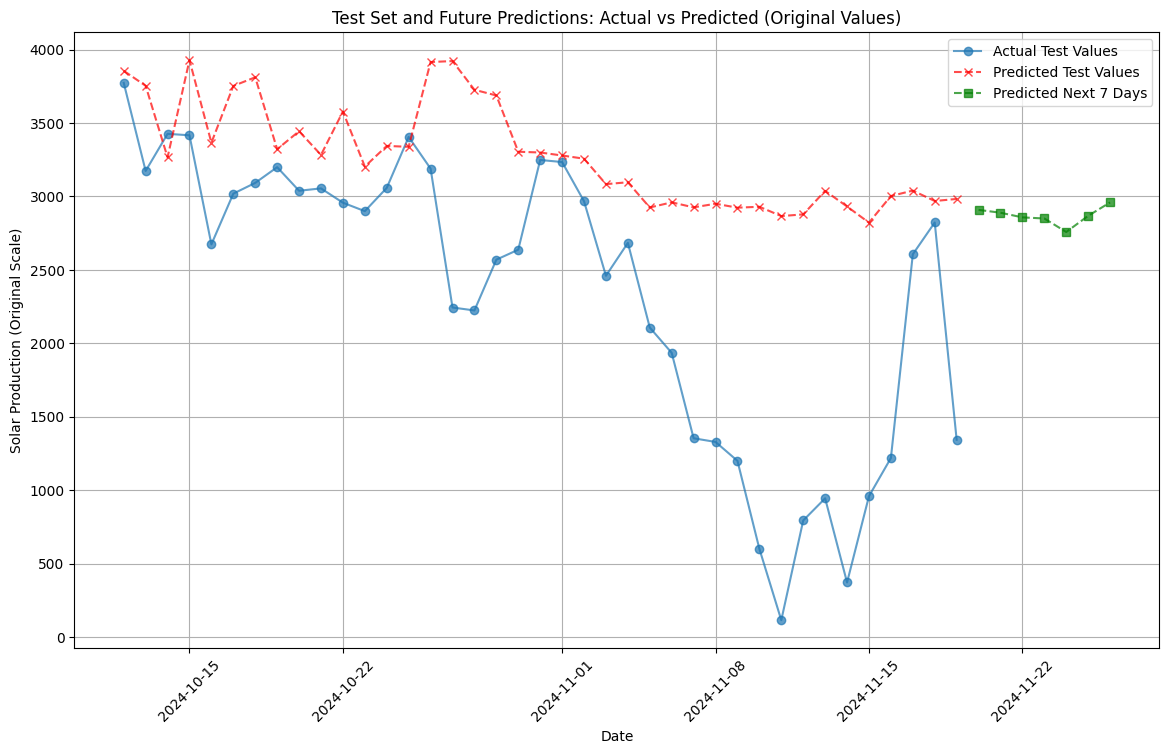

In [168]:
# Reverse the log transformation
y_test_pred_actual = np.exp(y_test_pred)  # Predicted values in original form for the test set
y_test_actual = np.exp(y_test)  # Actual values in original form for the test set

# Create a DataFrame for test set visualization
test_results_actual = pd.DataFrame({
    'Date': X_test.index,  # Dates corresponding to the test set
    'Actual': y_test_actual,
    'Predicted': y_test_pred_actual
})

# Add the next 7 days predicted values
# Future predictions have already been calculated as `future_predictions_actual` in the future_results DataFrame
future_results_for_plot = future_results[['Date', 'Predicted (Actual)']].rename(columns={'Predicted (Actual)': 'Predicted'})
future_results_for_plot['Actual'] = np.nan  # No actual values available for future predictions

# Combine the test set and future predictions into one DataFrame for plotting
combined_results = pd.concat([test_results_actual, future_results_for_plot], ignore_index=True)

# Plot the actual and predicted values (test set and next 7 days predictions)
plt.figure(figsize=(14, 8))

# Plot the actual test values
plt.plot(test_results_actual['Date'], test_results_actual['Actual'], label="Actual Test Values", marker='o', linestyle='-', alpha=0.7)

# Plot the predicted test values
plt.plot(test_results_actual['Date'], test_results_actual['Predicted'], label="Predicted Test Values", marker='x', linestyle='--', alpha=0.7, color='red')

# Plot the predicted future values
plt.plot(future_results_for_plot['Date'], future_results_for_plot['Predicted'], label="Predicted Next 7 Days", marker='s', linestyle='--', alpha=0.7, color='green')

# Add labels and title
plt.title("Test Set and Future Predictions: Actual vs Predicted (Original Values)")
plt.xlabel("Date")
plt.ylabel("Solar Production (Original Scale)")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

# **Predicted Data Store In MongoDB:**

In [170]:
%%capture
!pip install pymongo

In [ ]:
from pymongo import MongoClient
import json

# Connect to the MongoDB server
client = MongoClient("mongodb://localhost:27017/")  # Update the connection string if necessary

# Access the database and collection
db = client['iotdb']
collection = db['solar_forcast']

# Prepare the test set predictions for MongoDB
test_data_for_mongo = test_results_actual.copy()
test_data_for_mongo['Type'] = 'Test'  # Add a column to identify these as test set predictions
test_data_for_mongo.reset_index(drop=True, inplace=True)

# Prepare the next 7 days predictions for MongoDB
future_data_for_mongo = future_results_for_plot.copy()
future_data_for_mongo['Type'] = 'Future'  # Add a column to identify these as future predictions
future_data_for_mongo.reset_index(drop=True, inplace=True)

# Combine both test and future predictions
combined_data_for_mongo = pd.concat([test_data_for_mongo, future_data_for_mongo], ignore_index=True)

# Convert the Date column to a string format to make it JSON serializable
combined_data_for_mongo['Date'] = pd.to_datetime(combined_data_for_mongo['Date'], errors='coerce')
combined_data_for_mongo['Date'] = combined_data_for_mongo['Date'].dt.strftime('%Y-%m-%d')

# Convert the DataFrame to a list of dictionaries (JSON format)
data_to_store = combined_data_for_mongo.to_dict(orient='records')

# Store the data in MongoDB
collection.insert_many(data_to_store)

# Confirm data insertion
print(f"Data successfully inserted into MongoDB collection '{collection.name}' in database '{db.name}'.")

# Optional: Print the inserted data excluding the `_id` field
for record in data_to_store[:5]:  # Display the first 5 records
    record.pop("_id", None)  # Remove the '_id' field if it exists
print(json.dumps(data_to_store[:5], indent=4))  # Print in JSON format
